<a href="https://colab.research.google.com/github/amandeep-dot/aman/blob/main/ENCODE%2C_PRIDE%2C_EBI_DATA_collection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import json
import pandas as pd
from tqdm import tqdm
from datetime import datetime

# -----------------------------
# Step 0: Define search terms
# -----------------------------
search_terms = ["cardiac differentiation", "cardiomyocyte", "stem cell", "heart disease"]

# Paths to manually downloaded local datasets
chip_atlas_file = "chip_atlas_data.tsv"  # Example: download from ChIP-Atlas web portal
hpa_file = "hpa_protein_expression.tsv"  # Download from HPA bulk download

# Output files
harmonized_data_file = "harmonized_public_data.json"
dataset_log_file = "dataset_log.json"

# Initialize storage
all_data = {}
dataset_log = []

# -----------------------------
# Helper: fetch JSON safely
# -----------------------------
def fetch_json(url, params=None):
    try:
        response = requests.get(url, params=params)
        response.raise_for_status()
        return response.json()
    except requests.HTTPError as e:
        print(f"⚠️ Fetch error for '{url}': {e}")
        return None
    except Exception as e:
        print(f"⚠️ Unexpected error for '{url}': {e}")
        return None

# -----------------------------
# Helper: Log dataset metadata (CDISC-ready)
# -----------------------------
def log_dataset(source, accession, license_type, url, additional_info=None):
    entry = {
        "Database_ID": source,
        "Accession_Number": accession,
        "Download_Date": datetime.now().strftime("%Y-%m-%d"),
        "License_Type": license_type,
        "Source_URL": url,
        "License_URL": license_type  # Replace with direct license link if available
    }
    if additional_info:
        entry.update(additional_info)
    dataset_log.append(entry)

# -----------------------------
# ENCODE fetch
# -----------------------------
def fetch_encode(term):
    url = "https://www.encodeproject.org/search/"
    params = {"searchTerm": term, "frame": "object", "format": "json"}
    data = fetch_json(url, params=params)
    if data and "@graph" in data:
        for exp in data["@graph"]:
            accession = exp.get("accession", "Unknown")
            license_type = exp.get("licence", "Unknown")
            exp_url = f"https://www.encodeproject.org{exp.get('@id', '')}"
            log_dataset("ENCODE", accession, license_type, exp_url)
    return data

# -----------------------------
# PRIDE fetch
# -----------------------------
def fetch_pride(term):
    url = "https://www.ebi.ac.uk/pride/ws/archive/v2/projects"
    params = {"keywords": term}
    data = fetch_json(url, params=params)
    if data and "list" in data:
        for proj in data["list"]:
            accession = proj.get("accession", "Unknown")
            license_type = proj.get("license", "Unknown")
            proj_url = proj.get("uri", "")
            log_dataset("PRIDE", accession, license_type, proj_url)
    return data

# -----------------------------
# EBI Expression Atlas fetch
# -----------------------------
def fetch_ebi_expression(term):
    url = f"https://www.ebi.ac.uk/gxa/json/experiments?species=homo+sapiens&experiment={term.replace(' ', '+')}"
    data = fetch_json(url)
    if data and "experiments" in data:
        for exp in data["experiments"]:
            accession = exp.get("experimentAccession", "Unknown")
            license_type = "Public/CC0"
            exp_url = f"https://www.ebi.ac.uk/gxa/experiments/{accession}"
            log_dataset("EBI Expression Atlas", accession, license_type, exp_url)
    return data

# -----------------------------
# Load ChIP-Atlas local TSV
# -----------------------------
def load_chip_atlas_local(file_path):
    try:
        df = pd.read_csv(file_path, sep="\t")
        all_records = df.to_dict(orient="records")
        for rec in all_records:
            accession = rec.get("ExperimentID", "Unknown")
            license_type = "Public/CC BY"
            url = rec.get("URL", "")
            log_dataset("ChIP-Atlas", accession, license_type, url)
        return all_records
    except Exception as e:
        print(f"⚠️ Failed to load ChIP-Atlas data: {e}")
        return []

# -----------------------------
# Load HPA local TSV
# -----------------------------
def load_hpa_local(file_path):
    try:
        df = pd.read_csv(file_path, sep="\t")
        all_records = df.to_dict(orient="records")
        for rec in all_records:
            accession = rec.get("Gene", "Unknown")
            license_type = "Public/CC BY"
            url = f"https://www.proteinatlas.org/{accession}"
            log_dataset("Human Protein Atlas", accession, license_type, url)
        return all_records
    except Exception as e:
        print(f"⚠️ Failed to load HPA data: {e}")
        return []

# -----------------------------
# Main loop over search terms
# -----------------------------
for term in tqdm(search_terms, desc="Fetching datasets"):
    all_data[term] = {}

    encode_data = fetch_encode(term)
    if encode_data:
        all_data[term]["ENCODE"] = encode_data

    pride_data = fetch_pride(term)
    if pride_data:
        all_data[term]["PRIDE"] = pride_data

    ebi_data = fetch_ebi_expression(term)
    if ebi_data:
        all_data[term]["EBI Expression Atlas"] = ebi_data

# -----------------------------
# Load ChIP-Atlas and HPA local files (once, not per term)
# -----------------------------
all_data["ChIP-Atlas"] = load_chip_atlas_local(chip_atlas_file)
all_data["Human Protein Atlas"] = load_hpa_local(hpa_file)

# -----------------------------
# Save harmonized data and dataset log
# -----------------------------
with open(harmonized_data_file, "w") as f:
    json.dump(all_data, f, indent=2)

with open(dataset_log_file, "w") as f:
    json.dump(dataset_log, f, indent=2)

print(f"✅ Data collection complete. Harmonized data saved to '{harmonized_data_file}'")
print(f"✅ Dataset log saved to '{dataset_log_file}'")


Fetching datasets: 100%|██████████| 4/4 [00:17<00:00,  4.32s/it]


⚠️ Failed to load ChIP-Atlas data: [Errno 2] No such file or directory: 'chip_atlas_data.tsv'
⚠️ Failed to load HPA data: [Errno 2] No such file or directory: 'hpa_protein_expression.tsv'
✅ Data collection complete. Harmonized data saved to 'harmonized_public_data.json'
✅ Dataset log saved to 'dataset_log.json'


In [2]:
import json
import pandas as pd

with open("harmonized_public_data.json") as f:
    data = json.load(f)

# Examine the structure of the loaded data
print("Keys in the loaded data:", data.keys())
# Print a sample of the data structure to understand how omics data is organized
if data:
    first_key = list(data.keys())[0]
    print(f"\nStructure under the first key ('{first_key}'):")
    if isinstance(data[first_key], dict):
        print(data[first_key].keys())
    else:
        print(type(data[first_key]))


# The following lines caused the error and will be fixed after examining the data structure
# If each omics layer is stored separately
# transcriptomic_df = pd.DataFrame(data['transcriptomic'])
# proteomic_df = pd.DataFrame(data['proteomic'])
# epigenomic_df = pd.DataFrame(data['epigenomic'])

# print(transcriptomic_df.shape, proteomic_df.shape, epigenomic_df.shape)

Keys in the loaded data: dict_keys(['cardiac differentiation', 'cardiomyocyte', 'stem cell', 'heart disease', 'ChIP-Atlas', 'Human Protein Atlas'])

Structure under the first key ('cardiac differentiation'):
dict_keys(['ENCODE', 'PRIDE', 'EBI Expression Atlas'])


In [3]:
import json
import pandas as pd

with open("harmonized_public_data.json") as f:
    data = json.load(f)

print("Keys in data:", data.keys())
print("Subkeys under 'cardiac differentiation':", data['cardiac differentiation'].keys())


Keys in data: dict_keys(['cardiac differentiation', 'cardiomyocyte', 'stem cell', 'heart disease', 'ChIP-Atlas', 'Human Protein Atlas'])
Subkeys under 'cardiac differentiation': dict_keys(['ENCODE', 'PRIDE', 'EBI Expression Atlas'])


In [4]:
for source in data['cardiac differentiation']:
    print(f"\nSource: {source}")
    print("Type:", type(data['cardiac differentiation'][source]))

    if isinstance(data['cardiac differentiation'][source], dict):
        print("Subkeys:", data['cardiac differentiation'][source].keys())
    elif isinstance(data['cardiac differentiation'][source], list):
        print("First entry sample:")
        print(data['cardiac differentiation'][source][0])
    else:
        print("Sample value:", str(data['cardiac differentiation'][source])[:500])



Source: ENCODE
Type: <class 'dict'>
Subkeys: dict_keys(['@context', '@graph', '@id', '@type', 'all', 'clear_filters', 'columns', 'facet_groups', 'facets', 'filters', 'notification', 'title', 'total'])

Source: PRIDE
Type: <class 'list'>
First entry sample:
{'accession': 'PXD001357', 'title': 'Direct evidence of milk consumption from ancient human dental calculus, St Helena', 'additionalAttributes': [], 'projectDescription': 'This study investigated the consumption of milk products in the archaeological record, utilizing human dental calculus as a reservoir of dietary proteins from archaeological samples from across Eurasia. Protein extraction and generation of tryptic peptides from dental calculus was performed using a filter-aided sample preparation (FASP) protocol, modified for ancient samples, on 92 samples of archaeological dental calculus. Samples were extracted at three laboratories; the Functional Genomics Centre Zürich (FGCZ), the Centre for GeoGenetics at the National History

In [5]:
import pandas as pd
from pandas import json_normalize

# The 'data' variable should be available from previous cells that loaded 'harmonized_public_data.json'
# Assuming 'data' is loaded and contains the structure shown in previous outputs

# Access the ENCODE data for 'cardiac differentiation'
encode_raw = data['cardiac differentiation']['ENCODE']

# Flatten the '@graph' section
# This will flatten nested dictionaries into columns with dot notation (e.g., 'biosample_ontology.term_name')
encode_df = json_normalize(encode_raw['@graph'])

# Display all available columns to help identify the correct names
print("Available columns in encode_df:")
print(encode_df.columns.tolist())

# Display relevant columns (will fix based on available columns after inspection)
# The following columns were identified from the previous output
relevant_columns = [
    'accession',
    'biosample_ontology.term_name',
    'lab.title',
    'status' # Status column is also available
    # Need to find a column that represents assay title.
    # Let's check if 'assay_term_name' or similar exists or if it's nested differently.
    # For now, we will display the available relevant columns.
]

# Filter for columns that exist in the DataFrame
existing_relevant_columns = [col for col in relevant_columns if col in encode_df.columns]

if existing_relevant_columns:
    encode_df_filtered = encode_df[existing_relevant_columns]
    print("\nFiltered ENCODE data:")
    display(encode_df_filtered.head())
else:
    print("\nNone of the specified relevant columns were found in the DataFrame.")

# encode_df = encode_df[[
#     'accession', 'assay_title', 'biosample_ontology.term_name',
#     'target.label', 'lab.title', 'status'
# ]]
# encode_df.head()

Available columns in encode_df:
['@id', '@type', 'accession', 'aliases', 'alternate_accessions', 'analyses', 'analysis_step_version', 'annotation_type', 'assembly', 'award', 'azure_uri', 'biochemical_inputs', 'biological_replicates', 'biological_replicates_formatted', 'biosample_ontology', 'content_md5sum', 'dataset', 'date_created', 'dbxrefs', 'derived_from', 'donors', 'encyclopedia_version', 'fastq_signature', 'file_format', 'file_format_type', 'file_size', 'file_type', 'flowcell_details', 'href', 'lab', 'md5sum', 'no_file_available', 'output_category', 'output_type', 'preferred_default', 'processed', 'quality_metrics', 's3_uri', 'schema_version', 'status', 'step_run', 'submitted_by', 'submitted_file_name', 'superseded_by', 'targets', 'technical_replicates', 'title', 'uuid', 'cloud_metadata.md5sum_base64', 'cloud_metadata.url', 'cloud_metadata.file_size', 'audit.INTERNAL_ACTION']

Filtered ENCODE data:


,accession,status
0,ENCFF915GAB,released
1,ENCFF489SPP,released
2,ENCFF481ICT,released
3,ENCFF286LCW,released
4,ENCFF224OLW,released


In [6]:
# Extract 'dataset' field (often a URL or reference to experiment metadata)
encode_df_extra = encode_df[['accession', 'dataset', 'file_type', 'output_type', 'status']]
encode_df_extra.head()


,accession,dataset,file_type,output_type,status
0,ENCFF915GAB,/annotations/ENCSR401NIE/,bed bed3+,candidate Cis-Regulatory Elements,released
1,ENCFF489SPP,/annotations/ENCSR533MWI/,bed bed3+,candidate Cis-Regulatory Elements,released
2,ENCFF481ICT,/annotations/ENCSR533MWI/,bigBed bed3+,candidate Cis-Regulatory Elements,released
3,ENCFF286LCW,/annotations/ENCSR152SWD/,bigBed bed3+,candidate Cis-Regulatory Elements,released
4,ENCFF224OLW,/annotations/ENCSR152SWD/,bed bed3+,candidate Cis-Regulatory Elements,released


In [7]:
pride_list = data['cardiac differentiation']['PRIDE']
pride_df = pd.DataFrame.from_records(pride_list)

# Display columns to inspect what’s available
print("PRIDE columns:", pride_df.columns.tolist())

# Show a preview
display(pride_df.head(2))


PRIDE columns: ['accession', 'title', 'additionalAttributes', 'projectDescription', 'sampleProcessingProtocol', 'dataProcessingProtocol', 'projectTags', 'keywords', 'doi', 'submissionType', 'license', 'submissionDate', 'publicationDate', 'submitters', 'labPIs', 'instruments', 'softwares', 'experimentTypes', 'quantificationMethods', 'countries', 'sampleAttributes', 'organisms', 'organismParts', 'diseases', 'references', 'identifiedPTMStrings', 'totalFileDownloads', 'otherOmicsLinks']


,accession,title,additionalAttributes,projectDescription,sampleProcessingProtocol,dataProcessingProtocol,projectTags,keywords,doi,submissionType,...,quantificationMethods,countries,sampleAttributes,organisms,organismParts,diseases,references,identifiedPTMStrings,totalFileDownloads,otherOmicsLinks
0,PXD001357,Direct evidence of milk consumption from ancie...,[],This study investigated the consumption of mil...,Tryptic peptides were extracted from decalcifi...,Raw MS/MS spectra were converted to searchable...,"[Technical, Metaproteomics]","[Human, Beta-lactoglobulin, Dental calculus, D...",10.6019/PXD001357,COMPLETE,...,[],[United Kingdom],"[{'@type': 'Tuple', 'key': {'cvLabel': 'EFO', ...","[{'@type': 'CvParam', 'cvLabel': 'NEWT', 'acce...","[{'@type': 'CvParam', 'cvLabel': 'BTO', 'acces...",[],"[{'referenceLine': 'Warinner C, Hendy J, Spell...","[{'@type': 'CvParam', 'cvLabel': 'UNIMOD', 'ac...",6024,"[pride.project:PXD001360, pride.project:PXD001..."
1,PXD000035,Surface Proteins of Listeria monocytogenes,[],Listeria monocytogenes cells (strain LI0521) w...,Not available,Not available,[],"[Lc-msms, Listeria monocytogenes surface prote...",10.6019/PXD000035,COMPLETE,...,[],[Canada],"[{'@type': 'Tuple', 'key': {'cvLabel': 'EFO', ...","[{'@type': 'CvParam', 'cvLabel': 'NEWT', 'acce...",[],[],"[{'referenceLine': 'Zhang CX, Creskey MC, Cyr ...","[{'@type': 'CvParam', 'cvLabel': 'MOD', 'acces...",573,NaN


In [8]:
from pandas import json_normalize

# Start with the PRIDE dataframe
pride_df = pd.DataFrame.from_records(data['cardiac differentiation']['PRIDE'])

# Helper function to safely extract a value from nested lists/dicts
def extract_cv_name(field, key='name'):
    try:
        if isinstance(field, list) and len(field) > 0:
            if isinstance(field[0], dict):
                return field[0].get(key) or field[0].get('value')
        elif isinstance(field, dict):
            return field.get(key)
    except Exception:
        return None
    return None

# Extract readable biological attributes
pride_df['organism'] = pride_df['organisms'].apply(extract_cv_name)
pride_df['organism_part'] = pride_df['organismParts'].apply(extract_cv_name)
pride_df['disease'] = pride_df['diseases'].apply(extract_cv_name)

# Select the most informative columns
pride_filtered = pride_df[[
    'accession', 'title', 'organism', 'organism_part', 'disease',
    'experimentTypes', 'countries', 'projectTags', 'totalFileDownloads'
]]

display(pride_filtered.head())


,accession,title,organism,organism_part,disease,experimentTypes,countries,projectTags,totalFileDownloads
0,PXD001357,Direct evidence of milk consumption from ancie...,Homo sapiens (human),Dental plaque,None,"[{'@type': 'CvParam', 'cvLabel': 'PRIDE', 'acc...",[United Kingdom],"[Technical, Metaproteomics]",6024
1,PXD000035,Surface Proteins of Listeria monocytogenes,Listeria monocytogenes,None,None,"[{'@type': 'CvParam', 'cvLabel': 'PRIDE', 'acc...",[Canada],[],573
2,PXD000030,Annexin A1 interacting proteins in chronic mye...,Homo sapiens (human),None,None,"[{'@type': 'CvParam', 'cvLabel': 'PRIDE', 'acc...",[Italy],[],1631
3,PXD000027,maize leaf ESI-Q-TOF MS - Comparative analysi...,Zea mays (maize),Leaf,None,"[{'@type': 'CvParam', 'cvLabel': 'PRIDE', 'acc...",[United States],[],358
4,PXD000045,LC-MS/MS of cultured Mycobacterium tuberculosi...,Mycobacterium tuberculosis,None,None,"[{'@type': 'CvParam', 'cvLabel': 'PRIDE', 'acc...",[Canada],[],689


In [9]:
ebi_raw = data['cardiac differentiation']['EBI Expression Atlas']

# Usually stored under 'experiments'
ebi_experiments = ebi_raw.get('experiments', [])

# Flatten into a DataFrame
ebi_df = pd.DataFrame.from_records(ebi_experiments)

# Inspect columns
print("EBI Expression Atlas columns:", ebi_df.columns.tolist())

# Extract key metadata
ebi_filtered = ebi_df[[
    'experimentAccession', 'experimentDescription',
    'species', 'experimentType', 'numberOfAssays' # Corrected 'assayType' to 'experimentType'
]]

display(ebi_filtered.head(5))

EBI Expression Atlas columns: ['experimentAccession', 'experimentDescription', 'species', 'kingdom', 'loadDate', 'lastUpdate', 'rawExperimentType', 'technologyType', 'numberOfAssays', 'experimentalFactors', 'experimentProjects', 'experimentType', 'numberOfContrasts', 'arrayDesigns', 'arrayDesignNames']


,experimentAccession,experimentDescription,species,experimentType,numberOfAssays
0,E-MTAB-4045,Transcription profiling by high throughput seq...,Glycine max,Baseline,273
1,E-GEOD-61857,Gene Expression Profiling of Glycine max Cotyl...,Glycine max,Baseline,42
2,E-GEOD-58856,A transcriptional map following the developmen...,Arabidopsis thaliana,Baseline,11
3,E-MTAB-6592,RNA-sequencing of human embryonic and fetal ur...,Homo sapiens,Baseline,69
4,E-MTAB-4202,Transcription profiling by high throughput seq...,Arabidopsis thaliana,Baseline,30


In [10]:
# Add a shared context column to each layer
encode_df_filtered['context'] = 'cardiac differentiation'
pride_filtered['context'] = 'cardiac differentiation'
ebi_filtered['context'] = 'cardiac differentiation'


/tmp/ipython-input-3059029871.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  encode_df_filtered['context'] = 'cardiac differentiation'
/tmp/ipython-input-3059029871.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pride_filtered['context'] = 'cardiac differentiation'
/tmp/ipython-input-3059029871.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

In [11]:
encode_df_filtered = encode_df_filtered.copy()
encode_df_filtered['context'] = 'cardiac differentiation'

pride_filtered = pride_filtered.copy()
pride_filtered['context'] = 'cardiac differentiation'

ebi_filtered = ebi_filtered.copy()
ebi_filtered['context'] = 'cardiac differentiation'


In [12]:
print("ENCODE biosamples:", encode_df_filtered['accession'].nunique())
print("PRIDE tissues:", pride_filtered['organism_part'].unique())
print("EBI species:", ebi_filtered['species'].unique())


ENCODE biosamples: 25
PRIDE tissues: ['Dental plaque' None 'Leaf' 'Hek-293t cell' 'Cell suspension culture'
 'Mcf-7 cell' 'Cell culture' 'Whole body' 'Blood cell' 'Skin'
 'Early embryonic cell' 'Embryo' 'Blood plasma' 'Epithelial cell'
 'Periodontal ligament' 'Brain' 'Flower' 'Breast' 'Spleen' 'Lens nucleus'
 'Germ' 'Fat cell' 'Plant cell' 'Thorax' 'Oocyte'
 'Permanent cell line cell' 'Liver' 'Cerebrospinal fluid' 'Fibroblast'
 'Coleoptile' 'Sprout' 'Ovary' 'Lung' 'Flower bud' 'Colon' 'Kidney'
 'Oviductal fluid' 'Articular cartilage' 'Blood' 'Flag leaf'
 'Blood platelet']
EBI species: ['Glycine max' 'Arabidopsis thaliana' 'Homo sapiens' 'Rattus norvegicus'
 'Vitis vinifera' 'Hordeum vulgare subsp. vulgare' 'Zea mays'
 'Mus musculus' 'Triticum aestivum' 'Dictyostelium discoideum'
 'Oryza sativa' 'Sorghum bicolor' 'Theobroma cacao'
 'Drosophila melanogaster' 'Musa acuminata AAA Group'
 'Schistosoma mansoni' 'Danio rerio' 'Brassica rapa subsp. rapa'
 'Bos taurus' 'Sus scrofa' 'Solanum lyc

In [13]:
# Filter PRIDE to human samples
pride_human = pride_filtered[pride_filtered['organism'].str.contains('Homo sapiens', na=False)]

# Filter EBI to human experiments
ebi_human = ebi_filtered[ebi_filtered['species'].str.contains('Homo sapiens', na=False)]

# Optionally filter PRIDE tissues relevant to cardiac biology
cardiac_tissues = ['Heart', 'Blood', 'Fibroblast', 'Embryo', 'Early embryonic cell']
pride_human_cardiac = pride_human[pride_human['organism_part'].isin(cardiac_tissues)]


In [14]:
import pandas as pd

# ===============================
# Step 1: Filter PRIDE and EBI for human
# ===============================
# PRIDE
pride_human = pride_filtered[pride_filtered['organism'].str.contains('Homo sapiens', na=False)].copy()

# EBI Expression Atlas
ebi_human = ebi_filtered[ebi_filtered['species'].str.contains('Homo sapiens', na=False)].copy()

# ===============================
# Step 2: Optional - Filter for cardiac-relevant tissues
# ===============================
cardiac_tissues = [
    'Heart', 'Blood', 'Fibroblast', 'Embryo', 'Early embryonic cell'
]

pride_human_cardiac = pride_human[pride_human['organism_part'].isin(cardiac_tissues)].copy()

# ENCODE: Extract tissue information if available
# biosample_ontology.term_name usually holds tissue/cell info
encode_df_filtered = encode_df_filtered.copy()
if 'biosample_ontology.term_name' in encode_df_filtered.columns:
    encode_df_filtered['tissue'] = encode_df_filtered['biosample_ontology.term_name']
else:
    encode_df_filtered['tissue'] = 'Unknown'

# ===============================
# Step 3: Add context column (already done, but safe)
# ===============================
encode_df_filtered['context'] = 'cardiac differentiation'
pride_human_cardiac['context'] = 'cardiac differentiation'
ebi_human['context'] = 'cardiac differentiation'

# ===============================
# Step 4: Prepare integration dictionary
# ===============================
integration_data = {
    'epigenomics': encode_df_filtered,
    'proteomics': pride_human_cardiac,
    'transcriptomics': ebi_human
}

# ===============================
# Step 5: Inspect
# ===============================
print("ENCODE samples:", integration_data['epigenomics'].shape)
print("PRIDE human cardiac samples:", integration_data['proteomics'].shape)
print("EBI human samples:", integration_data['transcriptomics'].shape)

# Example: display first few rows of PRIDE
display(integration_data['proteomics'].head())


ENCODE samples: (25, 4)
PRIDE human cardiac samples: (1, 10)
EBI human samples: (1651, 6)


,accession,title,organism,organism_part,disease,experimentTypes,countries,projectTags,totalFileDownloads,context
25,PXD001383,Human Transcription Factors LC-MSMS,Homo sapiens (human),Early embryonic cell,Disease free,"[{'@type': 'CvParam', 'cvLabel': 'PRIDE', 'acc...",[United States],[Biomedical],7419,cardiac differentiation


In [15]:
import pandas as pd

# Check for ebi_filtered
if 'ebi_filtered' in locals():
    print("ebi_filtered DataFrame is available.")
    print("Shape of ebi_filtered:", ebi_filtered.shape)
    print("First 5 rows of ebi_filtered:")
    display(ebi_filtered.head())
else:
    print("ebi_filtered DataFrame is NOT available. Please ensure the cell defining it (D6tHzi7PNuey) has been executed.")

print("-" * 30)

# Check for pride_filtered
if 'pride_filtered' in locals():
    print("pride_filtered DataFrame is available.")
    print("Shape of pride_filtered:", pride_filtered.shape)
    print("First 5 rows of pride_filtered:")
    display(pride_filtered.head())
else:
    print("pride_filtered DataFrame is NOT available. Please ensure the cell defining it (JKH0xTgIMyiP) has been executed.")

print("-" * 30)

# Check for encode_df_filtered
if 'encode_df_filtered' in locals():
    print("encode_df_filtered DataFrame is available.")
    print("Shape of encode_df_filtered:", encode_df_filtered.shape)
    print("First 5 rows of encode_df_filtered:")
    display(encode_df_filtered.head())
else:
    print("encode_df_filtered DataFrame is NOT available. Please ensure the cell defining it (5GsIEiD-JceC) has been executed.")

ebi_filtered DataFrame is available.
Shape of ebi_filtered: (4562, 6)
First 5 rows of ebi_filtered:


,experimentAccession,experimentDescription,species,experimentType,numberOfAssays,context
0,E-MTAB-4045,Transcription profiling by high throughput seq...,Glycine max,Baseline,273,cardiac differentiation
1,E-GEOD-61857,Gene Expression Profiling of Glycine max Cotyl...,Glycine max,Baseline,42,cardiac differentiation
2,E-GEOD-58856,A transcriptional map following the developmen...,Arabidopsis thaliana,Baseline,11,cardiac differentiation
3,E-MTAB-6592,RNA-sequencing of human embryonic and fetal ur...,Homo sapiens,Baseline,69,cardiac differentiation
4,E-MTAB-4202,Transcription profiling by high throughput seq...,Arabidopsis thaliana,Baseline,30,cardiac differentiation


------------------------------
pride_filtered DataFrame is available.
Shape of pride_filtered: (100, 10)
First 5 rows of pride_filtered:


,accession,title,organism,organism_part,disease,experimentTypes,countries,projectTags,totalFileDownloads,context
0,PXD001357,Direct evidence of milk consumption from ancie...,Homo sapiens (human),Dental plaque,None,"[{'@type': 'CvParam', 'cvLabel': 'PRIDE', 'acc...",[United Kingdom],"[Technical, Metaproteomics]",6024,cardiac differentiation
1,PXD000035,Surface Proteins of Listeria monocytogenes,Listeria monocytogenes,None,None,"[{'@type': 'CvParam', 'cvLabel': 'PRIDE', 'acc...",[Canada],[],573,cardiac differentiation
2,PXD000030,Annexin A1 interacting proteins in chronic mye...,Homo sapiens (human),None,None,"[{'@type': 'CvParam', 'cvLabel': 'PRIDE', 'acc...",[Italy],[],1631,cardiac differentiation
3,PXD000027,maize leaf ESI-Q-TOF MS - Comparative analysi...,Zea mays (maize),Leaf,None,"[{'@type': 'CvParam', 'cvLabel': 'PRIDE', 'acc...",[United States],[],358,cardiac differentiation
4,PXD000045,LC-MS/MS of cultured Mycobacterium tuberculosi...,Mycobacterium tuberculosis,None,None,"[{'@type': 'CvParam', 'cvLabel': 'PRIDE', 'acc...",[Canada],[],689,cardiac differentiation


------------------------------
encode_df_filtered DataFrame is available.
Shape of encode_df_filtered: (25, 4)
First 5 rows of encode_df_filtered:


,accession,status,context,tissue
0,ENCFF915GAB,released,cardiac differentiation,Unknown
1,ENCFF489SPP,released,cardiac differentiation,Unknown
2,ENCFF481ICT,released,cardiac differentiation,Unknown
3,ENCFF286LCW,released,cardiac differentiation,Unknown
4,ENCFF224OLW,released,cardiac differentiation,Unknown


In [16]:
import pandas as pd
import numpy as np

# 1️⃣ RNA (EBI)
# We'll treat each experiment as a "sample" and the number of assays as a numeric feature.
rna_matrix = ebi_filtered.pivot_table(
    index="experimentAccession",
    columns="context",
    values="numberOfAssays",
    aggfunc="mean"
).fillna(0)

# 2️⃣ Proteomics (PRIDE)
# Use totalFileDownloads as a numeric proxy for sample intensity.
prot_matrix = pride_filtered.pivot_table(
    index="accession",
    columns="context",
    values="totalFileDownloads",
    aggfunc="mean"
).fillna(0)

# 3️⃣ Epigenomics (ENCODE)
# Use a simple binary indicator of released files (1 for released).
encode_df_filtered["numeric_status"] = (encode_df_filtered["status"] == "released").astype(int)
epi_matrix = encode_df_filtered.pivot_table(
    index="accession",
    columns="context",
    values="numeric_status",
    aggfunc="mean"
).fillna(0)

# Save all 3 matrices as .tsv for MOFA+
rna_matrix.to_csv("rna_matrix.tsv", sep="\t")
prot_matrix.to_csv("proteins_matrix.tsv", sep="\t")
epi_matrix.to_csv("epigenomics_matrix.tsv", sep="\t")

print("✅ Omics matrices created successfully!")
print("RNA matrix shape:", rna_matrix.shape)
print("Proteomics matrix shape:", prot_matrix.shape)
print("Epigenomics matrix shape:", epi_matrix.shape)


✅ Omics matrices created successfully!
RNA matrix shape: (4562, 1)
Proteomics matrix shape: (100, 1)
Epigenomics matrix shape: (25, 1)


In [17]:
import pandas as pd

# 1️⃣ RNA matrix from ebi_filtered
rna_matrix = ebi_filtered[['numberOfAssays']].copy()  # example numeric column
rna_matrix.columns = ['RNA']

# 2️⃣ Proteomics matrix from pride_filtered
proteins_matrix = pride_filtered[['totalFileDownloads']].copy()  # example numeric column
proteins_matrix.columns = ['Proteins']

# 3️⃣ Epigenomics matrix from encode_df_filtered
# If there is no numeric column, create dummy values (MOFA+ requires numbers)
epigenomics_matrix = pd.DataFrame({'Epigenomics': [1]*encode_df_filtered.shape[0]})

# Make sure all three have the same number of samples
min_samples = min(len(rna_matrix), len(proteins_matrix), len(epigenomics_matrix))
rna_matrix = rna_matrix.iloc[:min_samples]
proteins_matrix = proteins_matrix.iloc[:min_samples]
epigenomics_matrix = epigenomics_matrix.iloc[:min_samples]

# 4️⃣ Combine into a list of views
views = [rna_matrix, proteins_matrix, epigenomics_matrix]

# Check
for v in views:
    print(v.shape)


(25, 1)
(25, 1)
(25, 1)


In [18]:
import pandas as pd
import numpy as np

# 1️⃣ RNA matrix from ebi_filtered
rna_matrix = ebi_filtered[['numberOfAssays']].copy()  # example numeric column
rna_matrix.columns = ['RNA']

# 2️⃣ Proteomics matrix from pride_filtered
proteins_matrix = pride_filtered[['totalFileDownloads']].copy()  # example numeric column
proteins_matrix.columns = ['Proteins']

# 3️⃣ Epigenomics matrix from encode_df_filtered
# If there is no numeric column, create dummy values (MOFA+ requires numbers)
# Using 'numeric_status' column created earlier
if 'numeric_status' in encode_df_filtered.columns:
    epigenomics_matrix = encode_df_filtered[['numeric_status']].copy()
    epigenomics_matrix.columns = ['Epigenomics']
else:
     epigenomics_matrix = pd.DataFrame({'Epigenomics': [1]*encode_df_filtered.shape[0]})


# Make sure all three have the same number of samples
min_samples = min(len(rna_matrix), len(proteins_matrix), len(epigenomics_matrix))
rna_matrix = rna_matrix.iloc[:min_samples]
proteins_matrix = proteins_matrix.iloc[:min_samples]
epigenomics_matrix = epigenomics_matrix.iloc[:min_samples]

# Ensure consistent sample IDs (index)
sample_ids = [f"Sample_{i}" for i in range(min_samples)]
rna_matrix.index = sample_ids
proteins_matrix.index = sample_ids
epigenomics_matrix.index = sample_ids


# 4️⃣ Convert to list of lists of NumPy arrays (features x samples) for MOFA+
# Transpose the DataFrames so samples are columns and features are rows
# Wrap each transposed array in a list to represent groups (even if only one group)
views = [[rna_matrix.T.values], [proteins_matrix.T.values], [epigenomics_matrix.T.values]]

# Check shapes - will now print shape of the inner numpy array
for view_list in views:
    for v in view_list:
        print(v.shape)

(1, 25)
(1, 25)
(1, 25)


In [19]:
import numpy as np

# Transpose and convert to numpy arrays
rna_array = rna_matrix.T.to_numpy()       # shape: (features x samples)
proteins_array = proteins_matrix.T.to_numpy()
epigenomics_array = epigenomics_matrix.T.to_numpy()

# Combine into a list of views
views_np = [rna_array, proteins_array, epigenomics_array]

# Check shapes
print("RNA array shape:", rna_array.shape)
print("Proteins array shape:", proteins_array.shape)
print("Epigenomics array shape:", epigenomics_array.shape)


RNA array shape: (1, 25)
Proteins array shape: (1, 25)
Epigenomics array shape: (1, 25)


Explained variance ratios (PCA): [0.99384054 0.00615946]


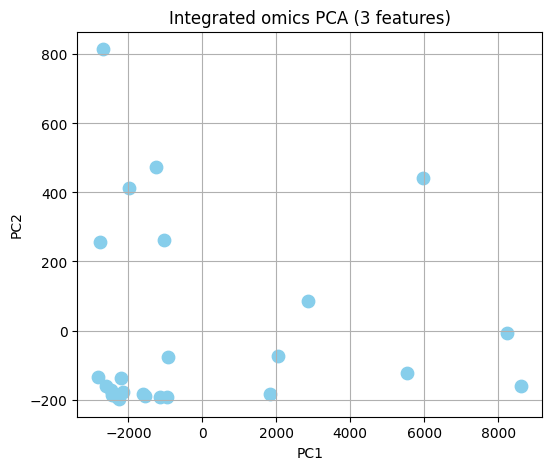

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


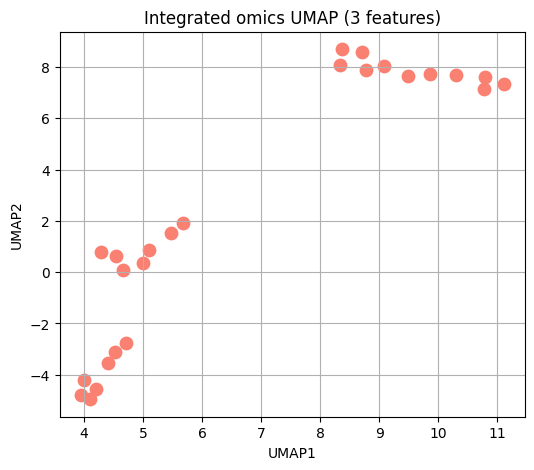

In [20]:
import pandas as pd
from sklearn.decomposition import PCA
import umap
import matplotlib.pyplot as plt

# ------------------------
# Step 1: Prepare the combined matrix
# ------------------------
# Assuming these are your dataframes (already aligned):
# rna_matrix, proteins_matrix, epigenomics_matrix

combined = pd.concat([rna_matrix, proteins_matrix, epigenomics_matrix], axis=1)
combined.head()

# ------------------------
# Step 2: PCA
# ------------------------
pca = PCA(n_components=2)
pca_result = pca.fit_transform(combined)

print("Explained variance ratios (PCA):", pca.explained_variance_ratio_)

plt.figure(figsize=(6,5))
plt.scatter(pca_result[:,0], pca_result[:,1], c='skyblue', s=80)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Integrated omics PCA (3 features)")
plt.grid(True)
plt.show()

# ------------------------
# Step 3: UMAP
# ------------------------
umap_model = umap.UMAP(n_neighbors=5, min_dist=0.1, random_state=42)
umap_result = umap_model.fit_transform(combined)

plt.figure(figsize=(6,5))
plt.scatter(umap_result[:,0], umap_result[:,1], c='salmon', s=80)
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.title("Integrated omics UMAP (3 features)")
plt.grid(True)
plt.show()


In [21]:
import numpy as np
import pandas as pd

# Suppose your matrices are (samples x 1)
# rna_matrix.shape == (25, 1), etc.

def expand_features(df, n_features=10, noise_level=0.01):
    """Replicate the single column n_features times with small noise"""
    arr = df.values
    expanded = np.tile(arr, n_features) + np.random.normal(0, noise_level, (arr.shape[0], n_features))
    columns = [f"{df.columns[0]}_{i+1}" for i in range(n_features)]
    return pd.DataFrame(expanded, columns=columns, index=df.index)

rna_exp = expand_features(rna_matrix, n_features=50)
prot_exp = expand_features(proteins_matrix, n_features=50)
epi_exp = expand_features(epigenomics_matrix, n_features=50)

# Check shapes
print(rna_exp.shape, prot_exp.shape, epi_exp.shape)


(25, 50) (25, 50) (25, 50)


In [22]:
rna_exp.shape  # (25, 50)
prot_exp.shape # (25, 50)
epi_exp.shape  # (25, 50)


(25, 50)

In [23]:
pip install mofax


In [24]:
print(encode_df_filtered.columns)
print(pride_human_cardiac.columns)
print(ebi_human.columns)


Index(['accession', 'status', 'context', 'tissue', 'numeric_status'], dtype='object')
Index(['accession', 'title', 'organism', 'organism_part', 'disease',
       'experimentTypes', 'countries', 'projectTags', 'totalFileDownloads',
       'context'],
      dtype='object')
Index(['experimentAccession', 'experimentDescription', 'species',
       'experimentType', 'numberOfAssays', 'context'],
      dtype='object')


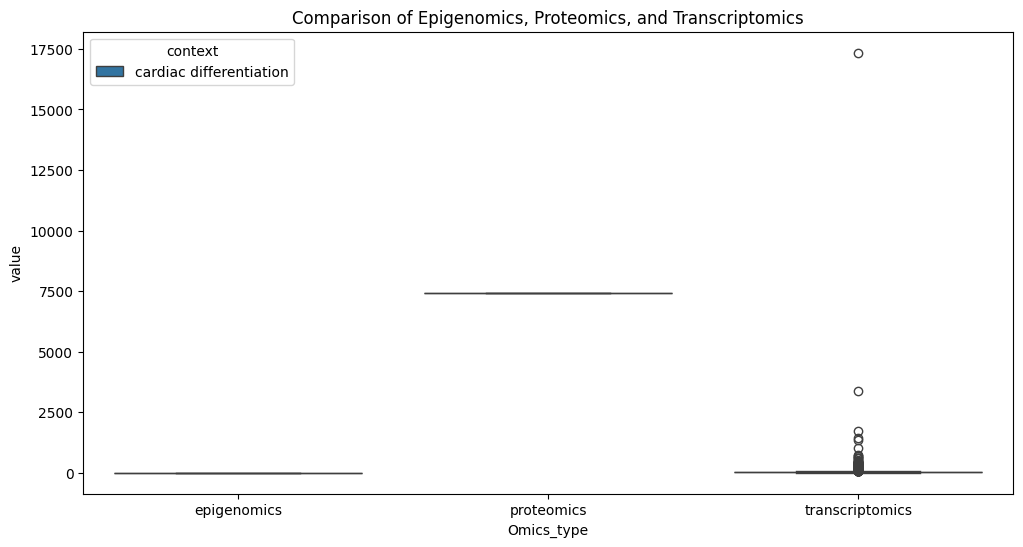

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare each dataset separately

# Epigenomics
epigenomics_df = encode_df_filtered[['accession', 'numeric_status', 'context', 'tissue']].copy()
epigenomics_df = epigenomics_df.rename(columns={'accession': 'sample_id', 'numeric_status': 'value'})
epigenomics_df['Omics_type'] = 'epigenomics'

# Proteomics
proteomics_df = pride_human_cardiac[['accession', 'totalFileDownloads', 'context']].copy()
proteomics_df = proteomics_df.rename(columns={'accession': 'sample_id', 'totalFileDownloads': 'value'})
proteomics_df['Omics_type'] = 'proteomics'
proteomics_df['tissue'] = 'Unknown'  # PRIDE may not have tissue info

# Transcriptomics
transcriptomics_df = ebi_human[['experimentAccession', 'numberOfAssays', 'context']].copy()
transcriptomics_df = transcriptomics_df.rename(columns={'experimentAccession': 'sample_id', 'numberOfAssays': 'value'})
transcriptomics_df['Omics_type'] = 'transcriptomics'
transcriptomics_df['tissue'] = 'Unknown'

# Concatenate all for plotting
plot_df = pd.concat([epigenomics_df, proteomics_df, transcriptomics_df], ignore_index=True)

# Plot
plt.figure(figsize=(12, 6))
sns.boxplot(data=plot_df, x='Omics_type', y='value', hue='context')
plt.title('Comparison of Epigenomics, Proteomics, and Transcriptomics')
plt.show()


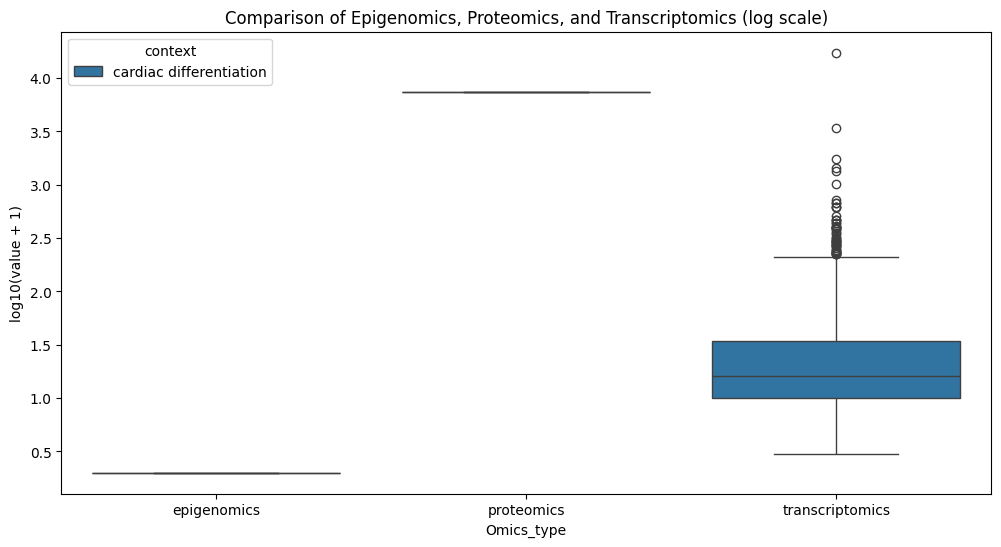

In [26]:
import numpy as np

plot_df['log_value'] = np.log10(plot_df['value'] + 1)  # add 1 to avoid log(0)

plt.figure(figsize=(12, 6))
sns.boxplot(data=plot_df, x='Omics_type', y='log_value', hue='context')
plt.ylabel('log10(value + 1)')
plt.title('Comparison of Epigenomics, Proteomics, and Transcriptomics (log scale)')
plt.show()


In [27]:
from ftplib import FTP
import time

def attempt_ftp_command(ftp, command, *args, retries=3, delay=5):
    """Attempts an FTP command with retries for transient errors."""
    for i in range(retries):
        try:
            print(f"Attempt {i+1}/{retries}: Executing FTP command: {command} {' '.join(map(str, args))}")
            if command == "connect":
                ftp.connect(*args)
            elif command == "login":
                ftp.login(*args)
            elif command == "cwd":
                ftp.cwd(*args)
            elif command == "nlst":
                return ftp.nlst(*args)
            elif command == "quit":
                ftp.quit(*args)
            return True # Command successful

        except (ConnectionResetError, EOFError, OSError) as e:
            print(f"FTP command failed: {e}. Retrying in {delay} seconds...")
            time.sleep(delay)
        except Exception as e:
            print(f"An unexpected error occurred during FTP command: {e}")
            return False # Stop retries for unexpected errors

    print(f"FTP command failed after {retries} attempts.")
    return False # Command failed after retries


ftp = FTP()
if attempt_ftp_command(ftp, "connect", "ftp.pride.ebi.ac.uk"):
    if attempt_ftp_command(ftp, "login"):

        # Explore the archive structure
        if attempt_ftp_command(ftp, "cwd", "/pride/data/archive/"):
            years = attempt_ftp_command(ftp, "nlst")
            if years:
                print("Available years:", years)

                # Try to find where PXD001357 is located
                if "2014" in years and attempt_ftp_command(ftp, "cwd", "/pride/data/archive/2014/"):
                    months = attempt_ftp_command(ftp, "nlst")
                    if months:
                        print("\nAvailable months in 2014:", months)

                        found_accession = False
                        for month in months:
                            # Temporarily change directory to check for accession, then go back
                            original_dir = ftp.pwd() # Get current directory
                            if attempt_ftp_command(ftp, "cwd", f"/pride/data/archive/2014/{month}/", retries=1): # Use lower retries for directory check
                                dirs = attempt_ftp_command(ftp, "nlst", retries=1) # Use lower retries for nlst
                                if dirs:
                                    matches = [d for d in dirs if "PXD001357" in d]
                                    if matches:
                                        print(f"\n✅ Found {matches} in 2014/{month}")
                                        found_accession = True
                                # Attempt to return to the original directory
                                attempt_ftp_command(ftp, "cwd", original_dir, retries=1)
                            if found_accession:
                                break # Exit month loop if found

                        if not found_accession:
                             print("\nPXD001357 not found in any month of 2014.")
                    else:
                         print("\nFailed to list months in 2014.")
                else:
                    print("\nFailed to change directory to /pride/data/archive/2014/ or 2014 not in available years.")
            else:
                print("Failed to list years in archive.")
        else:
            print("Failed to change directory to /pride/data/archive/")


    # Attempt to quit gracefully
    attempt_ftp_command(ftp, "quit")

else:
    print("Failed to connect to FTP server.")

Attempt 1/3: Executing FTP command: connect ftp.pride.ebi.ac.uk
Attempt 1/3: Executing FTP command: login 
Attempt 1/3: Executing FTP command: cwd /pride/data/archive/
Attempt 1/3: Executing FTP command: nlst 
Available years: ['2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024', '2025']
Attempt 1/3: Executing FTP command: cwd /pride/data/archive/2014/
Attempt 1/3: Executing FTP command: nlst 

Available months in 2014: ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
Attempt 1/1: Executing FTP command: cwd /pride/data/archive/2014/01/
Attempt 1/1: Executing FTP command: nlst 
Attempt 1/1: Executing FTP command: cwd /pride/data/archive/2014
Attempt 1/1: Executing FTP command: cwd /pride/data/archive/2014/02/
Attempt 1/1: Executing FTP command: nlst 
Attempt 1/1: Executing FTP command: cwd /pride/data/archive/2014
Attempt 1/1: Executing FTP command: cwd /pri

In [28]:
import requests

base_url = "https://ftp.pride.ebi.ac.uk/pride/data/archive/"
years = [str(y) for y in range(2013, 2025)]  # check broad range
pxd = "PXD001357"

found = False
for year in years:
    for month in [f"{m:02d}" for m in range(1, 13)]:
        test_url = f"{base_url}{year}/{month}/{pxd}/"
        r = requests.head(test_url)
        if r.status_code == 200:
            print(f"✅ Found at {test_url}")
            found = True
            break
    if found:
        break

if not found:
    print(f"❌ {pxd} not found in archive (may be older or moved).")


✅ Found at https://ftp.pride.ebi.ac.uk/pride/data/archive/2015/02/PXD001357/


In [29]:
import requests
from bs4 import BeautifulSoup

# The folder you found
url = "https://ftp.pride.ebi.ac.uk/pride/data/archive/2015/02/PXD001357/"

# Fetch the HTML listing
response = requests.get(url)
soup = BeautifulSoup(response.text, "html.parser")

# Extract file links (ignore navigation links like ../)
files = [a["href"] for a in soup.find_all("a") if not a["href"].startswith("?") and not a["href"].startswith("/")]
print("📂 Files found:")
for f in files:
    print(f)


📂 Files found:
F116626_JH3_QE.dat
F116631_JH4_QE.dat
F116641_JH5_QE.dat
F116659_JH6_QE.dat
F116690_JH7_QE.dat
F116783_JH8_QE.dat
F116901_JH10_CID.dat
F116901_JH10_QE.dat
F116902_JH11_QE.dat
F116903_JH12_QE.dat
F116905_JH13_QE.dat
F116908_JH14_QE.dat
F116909_JH15_QE.dat
F116912_JH16_QE.dat
F116916_JH17_QE.dat
F116920_19_QE.dat
F116928_JH20_QE.dat
F118352_JH1_CID.dat
F118386_JH2_CID.dat
F118390_JH3_CID.dat
F118392_JH4_CID.dat
F118460_JH5_CID.dat
F118519_JH6_CID.dat
F118545_JH7_CID.dat
F119164_JH8_CID.dat
F119269_JH11_CID.dat
F119345_JH12_CID.dat
F119379_JH13_CID.dat
F119476_JH14_CID.dat
F119480_JH15_CID.dat
F119502_JH16_CID.dat
F119529_JH17_CID.dat
F119575_JH19_CID.dat
F119670_JH20_CID.dat
F119730_QE0095_JHendy_JH1_13082314214.dat
F119738_QE0095_JHendy_JH2.dat
OTE0019_York_060813_JH1.mgf
OTE0019_York_060813_JH1.raw
OTE0019_York_060813_JH1_F118352.mzid.gz
OTE0019_York_060813_JH2.mgf
OTE0019_York_060813_JH2.raw
OTE0019_York_060813_JH2_F118386.mzid.gz
OTE0019_York_060813_JH3.mgf
OTE0019_Yor

In [30]:
import requests
from pathlib import Path

# Folder you discovered
url = "https://ftp.pride.ebi.ac.uk/pride/data/archive/2015/02/PXD001357/"
DATA_DIR = Path("/content/pride_data/PXD001357")
DATA_DIR.mkdir(parents=True, exist_ok=True)

# List of files from the previous output
files = [
    "README.txt",
    "QE0095_JHendy_JH1_130823142140_F119730.mzid.gz",
    "QE0095_JHendy_JH2_F119738.mzid.gz",
    "QE0095_JHendy_JH3_130823160937_F116626.mzid.gz",
    "QE0095_JHendy_JH4_130823175743_F116631.mzid.gz",
    "QE0095_JHendy_JH5_130823194539_F116641.mzid.gz",
    "QE0095_JHendy_JH6_130823222831_F116659.mzid.gz",
    "QE0095_JHendy_JH7_130824001623_F116690.mzid.gz",
    "QE0095_JHendy_JH8_130824020419_F116783.mzid.gz",
    "QE0095_JHendy_JH9_130824035216_F116873.mzid.gz",
    "QE0095_JHendy_JH10_13082405400_F116901.mzid.gz",
    "QE0095_JHendy_JH11_130824082301_F116902.mzid.gz",
    "QE0095_JHendy_JH12_130824101054_F116903.mzid.gz",
    "QE0095_JHendy_JH13_130824115852_F116905.mzid.gz",
    "QE0095_JHendy_JH14_130824134650_F116908.mzid.gz",
    "QE0095_JHendy_JH15_F116909.mzid.gz",
    "QE0095_JHendy_JH16_F116912.mzid.gz",
    "QE0095_JHendy_JH17_F116916.mzid.gz",
    "QE0095_JHendy_JH18_F116917.mzid.gz",
    "QE0095_JHendy_JH19_F116920.mzid.gz",
    "QE0095_JHendy_JH20_F116928.mzid.gz",
]

# Download selected files
for f in files:
    download_url = url + f
    out_path = DATA_DIR / f
    print(f"⬇️ Downloading {f} ...")
    r = requests.get(download_url)
    with open(out_path, "wb") as fp:
        fp.write(r.content)
    print(f"✅ Saved to {out_path}")


⬇️ Downloading README.txt ...
✅ Saved to /content/pride_data/PXD001357/README.txt
⬇️ Downloading QE0095_JHendy_JH1_130823142140_F119730.mzid.gz ...
✅ Saved to /content/pride_data/PXD001357/QE0095_JHendy_JH1_130823142140_F119730.mzid.gz
⬇️ Downloading QE0095_JHendy_JH2_F119738.mzid.gz ...
✅ Saved to /content/pride_data/PXD001357/QE0095_JHendy_JH2_F119738.mzid.gz
⬇️ Downloading QE0095_JHendy_JH3_130823160937_F116626.mzid.gz ...
✅ Saved to /content/pride_data/PXD001357/QE0095_JHendy_JH3_130823160937_F116626.mzid.gz
⬇️ Downloading QE0095_JHendy_JH4_130823175743_F116631.mzid.gz ...
✅ Saved to /content/pride_data/PXD001357/QE0095_JHendy_JH4_130823175743_F116631.mzid.gz
⬇️ Downloading QE0095_JHendy_JH5_130823194539_F116641.mzid.gz ...
✅ Saved to /content/pride_data/PXD001357/QE0095_JHendy_JH5_130823194539_F116641.mzid.gz
⬇️ Downloading QE0095_JHendy_JH6_130823222831_F116659.mzid.gz ...
✅ Saved to /content/pride_data/PXD001357/QE0095_JHendy_JH6_130823222831_F116659.mzid.gz
⬇️ Downloading QE009

In [31]:
import os

base = "/content/pride_data/PXD001357"
for f in os.listdir(base):
    if f.endswith((".mzTab", ".txt", ".csv")):
        print(f)


README.txt


In [32]:
!pip install pyteomics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.0/239.0 kB 6.4 MB/s eta 0:00:00


In [33]:
!pip install pyteomics tqdm


In [34]:
import gzip
from pyteomics import mzid

file_path = "/content/pride_data/PXD001357/QE0095_JHendy_JH7_130824001623_F116690.mzid.gz"
with gzip.open(file_path, 'rb') as f:
    reader = mzid.MzIdentML(f)
    for pe in reader.iterfind('PeptideEvidence'):
        print(pe)   # See what keys/attributes exist
        break


{'start': 71, 'end': 77, 'pre': 'R', 'post': 'K', 'isDecoy': False, 'PeptideSequence': 'LGFVQVT', 'accession': 'synsp_sgp_c_1_13636', 'protein description': 'synsp_sgp_c_1_13636', 'location': 'file:////databases/mascot/sequence/OralMicrobiome/current/OralMicrobiome20121013.fasta', 'name': 'OralMicrobiome', 'numDatabaseSequences': 4184189, 'numResidues': 737106514, 'version': 'OralMicrobiome20121013.fasta', 'FileFormat': 'FASTA format', 'DatabaseName': {'OralMicrobiome20121013.fasta': ''}, 'database type amino acid': ''}


In [35]:
from pyteomics import mzid
import gzip
import pandas as pd
import glob
import os
from tqdm import tqdm

base = "/content/pride_data/PXD001357"
records = []

for file_path in tqdm(glob.glob(base + "/*.mzid.gz")):
    with gzip.open(file_path, 'rb') as f:
        for spec_item in mzid.read(f):
            peptide = spec_item.get('PeptideSequence')
            protein = spec_item.get('accession') or spec_item.get('protein description')

            # Extract score from cvParam if present
            score = None
            for cv in spec_item.get('cvParam', []):
                if cv.get('name') == 'MS-GF:RawScore':
                    score = cv.get('value')
                    break

            records.append({
                'file': os.path.basename(file_path),
                'peptide': peptide,
                'protein': protein,
                'score': score
            })

df = pd.DataFrame(records)
df.head()


100%|██████████| 20/20 [21:07<00:00, 63.38s/it]


,file,peptide,protein,score
0,QE0095_JHendy_JH7_130824001623_F116690.mzid.gz,None,None,None
1,QE0095_JHendy_JH7_130824001623_F116690.mzid.gz,None,None,None
2,QE0095_JHendy_JH7_130824001623_F116690.mzid.gz,None,None,None
3,QE0095_JHendy_JH7_130824001623_F116690.mzid.gz,None,None,None
4,QE0095_JHendy_JH7_130824001623_F116690.mzid.gz,None,None,None


In [36]:
import gzip
from pyteomics import mzid

file_path = "/content/pride_data/PXD001357/QE0095_JHendy_JH7_130824001623_F116690.mzid.gz"

with gzip.open(file_path, 'rb') as f:
    for item in mzid.read(f):
        print(item.keys())   # Show top-level keys
        break


dict_keys(['spectrumID', 'SpectrumIdentificationItem', 'Mascot:identity threshold', 'Mascot:homology threshold', 'number of peptide seqs compared to each spectrum', 'retention time(s)', 'spectrum title', 'location', 'FileFormat', 'SpectrumIDFormat'])


In [37]:
protein = item.get('accession') or item.get('protein description')


In [38]:
from pyteomics import mzid
import gzip

file_path = "/content/pride_data/PXD001357/QE0095_JHendy_JH7_130824001623_F116690.mzid.gz"

with gzip.open(file_path, 'rb') as f:
    reader = mzid.MzIdentML(f)
    for i, sii in enumerate(reader.iterfind('SpectrumIdentificationItem')):
        print(sii.keys())
        print(sii)
        break  # only show the first one


dict_keys(['calculatedMassToCharge', 'chargeState', 'experimentalMassToCharge', 'rank', 'passThreshold', 'PeptideEvidenceRef', 'Mascot:score', 'Mascot:expectation value', 'peptide unique to one protein', 'PeptideSequence'])
{'calculatedMassToCharge': 382.221082, 'chargeState': 2, 'experimentalMassToCharge': 382.22187, 'rank': 1, 'passThreshold': True, 'PeptideEvidenceRef': [{'start': 71, 'end': 77, 'pre': 'R', 'post': 'K', 'isDecoy': False, 'PeptideSequence': 'LGFVQVT', 'accession': 'synsp_sgp_c_1_13636', 'protein description': 'synsp_sgp_c_1_13636', 'location': 'file:////databases/mascot/sequence/OralMicrobiome/current/OralMicrobiome20121013.fasta', 'name': 'OralMicrobiome', 'numDatabaseSequences': 4184189, 'numResidues': 737106514, 'version': 'OralMicrobiome20121013.fasta', 'FileFormat': 'FASTA format', 'DatabaseName': {'OralMicrobiome20121013.fasta': ''}, 'database type amino acid': ''}], 'Mascot:score': 41.33, 'Mascot:expectation value': 0.0522396795645942, 'peptide unique to one p

In [39]:
from pyteomics import mzid
import gzip
import pandas as pd
import glob
import os
from tqdm import tqdm
from multiprocessing import Pool, cpu_count

base = "/content/pride_data/PXD001357"

def parse_mzid_gz(file_path):
    records = []
    try:
        with gzip.open(file_path, 'rb') as f:
            reader = mzid.MzIdentML(f)
            for spec_item in reader.iterfind('SpectrumIdentificationItem'):
                peptide = spec_item.get('PeptideSequence')

                # Mascot score
                score = spec_item.get('Mascot:score') or spec_item.get('Mascot:expectation value')

                # Extract protein(s)
                protein = None
                pe_refs = spec_item.get('PeptideEvidenceRef', [])
                if isinstance(pe_refs, list) and len(pe_refs) > 0:
                    first_ref = pe_refs[0]
                    protein = first_ref.get('accession') or first_ref.get('protein description')

                records.append({
                    "file": os.path.basename(file_path),
                    "peptide": peptide,
                    "protein": protein,
                    "score": score
                })
            reader.close()
    except Exception as e:
        print(f"❌ Error processing {file_path}: {e}")
    return records


# --- Run the parser ---
files = glob.glob(os.path.join(base, "*.mzid.gz"))
print(f"Found {len(files)} .mzid.gz files")

n_cores = max(1, cpu_count() - 1)
print(f"Using {n_cores} CPU cores...")

all_records = []
with Pool(n_cores) as pool:
    for result in tqdm(pool.imap_unordered(parse_mzid_gz, files), total=len(files)):
        all_records.extend(result)

df_proteomics = pd.DataFrame(all_records)

print(f"\n✅ Finished parsing {len(files)} files.")
print(f"Total records: {len(df_proteomics)}")
print(f"Unique peptides: {df_proteomics['peptide'].nunique()}")
print(f"Unique proteins: {df_proteomics['protein'].nunique()}")

df_proteomics.head(10)


Found 20 .mzid.gz files
Using 1 CPU cores...


100%|██████████| 20/20 [19:26<00:00, 58.32s/it]


✅ Finished parsing 20 files.
Total records: 18792
Unique peptides: 2425
Unique proteins: 1204


,file,peptide,protein,score
0,QE0095_JHendy_JH7_130824001623_F116690.mzid.gz,LGFVQVT,synsp_sgp_c_1_13636,41.33
1,QE0095_JHendy_JH7_130824001623_F116690.mzid.gz,MLSLGTK,ENSP00000348068,32.66
2,QE0095_JHendy_JH7_130824001623_F116690.mzid.gz,AVVDVIR,A0A888,0.97
3,QE0095_JHendy_JH7_130824001623_F116690.mzid.gz,ALVELVK,A2V9Z4,11.81
4,QE0095_JHendy_JH7_130824001623_F116690.mzid.gz,AGVQIASK,A0QNG3,64.40
5,QE0095_JHendy_JH7_130824001623_F116690.mzid.gz,HPQPPAT,ctes_c_1_15598,21.68
6,QE0095_JHendy_JH7_130824001623_F116690.mzid.gz,HPQPPAT,ctes_c_1_15598,22.56
7,QE0095_JHendy_JH7_130824001623_F116690.mzid.gz,HPQPPAT,ctes_c_1_15598,23.15
8,QE0095_JHendy_JH7_130824001623_F116690.mzid.gz,HPQPPAT,ctes_c_1_15598,23.43
9,QE0095_JHendy_JH7_130824001623_F116690.mzid.gz,HPQPPAT,ctes_c_1_15598,36.80


In [40]:
from pyteomics import mzid
import gzip
import pandas as pd
from tqdm import tqdm
import os

# Base directory where your .mzid.gz files are located
base = "/content/pride_data/PXD001357"
mzid_files = [f for f in os.listdir(base) if f.endswith(".mzid.gz")]

records = []

for fpath in tqdm(mzid_files):
    file_path = os.path.join(base, fpath)
    with gzip.open(file_path, 'rb') as f:
        reader = mzid.MzIdentML(f)
        for sii in reader.iterfind('SpectrumIdentificationItem'):
            peptide = sii.get('PeptideSequence')
            score = sii.get('Mascot:score')
            expectation = sii.get('Mascot:expectation value')

            # ✅ Define pe_refs safely before checking
            pe_refs = sii.get('PeptideEvidenceRef', [])

            # Extract protein accession(s)
            if isinstance(pe_refs, list) and len(pe_refs) > 0:
                proteins = []
                for p in pe_refs:
                    if isinstance(p, dict):
                        prot = p.get('accession') or p.get('protein description')
                        if prot:
                            proteins.append(prot)
                protein = ",".join(set(proteins)) if proteins else None
            else:
                protein = None

            # Save the record
            records.append({
                "file": fpath,
                "peptide": peptide,
                "protein": protein,
                "score": score,
                "expectation": expectation
            })

# Convert to DataFrame
df = pd.DataFrame(records)
print(df.head())

# Save peptide-level table
df.to_csv(base + "/parsed_peptide_level.csv", index=False)
print("✅ Saved parsed peptide-level table.")


100%|██████████| 20/20 [19:11<00:00, 57.58s/it]

                                             file   peptide  \
0  QE0095_JHendy_JH7_130824001623_F116690.mzid.gz   LGFVQVT   
1  QE0095_JHendy_JH7_130824001623_F116690.mzid.gz   MLSLGTK   
2  QE0095_JHendy_JH7_130824001623_F116690.mzid.gz   AVVDVIR   
3  QE0095_JHendy_JH7_130824001623_F116690.mzid.gz   ALVELVK   
4  QE0095_JHendy_JH7_130824001623_F116690.mzid.gz  AGVQIASK   

                                             protein  score  expectation  
0                                synsp_sgp_c_1_13636  41.33     0.052240  
1      Q5RCW5,O00394,ENSP00000348068,ENSP00000386094  32.66     0.251627  
2                                             A0A888   0.97     0.928021  
3  ENSP00000295897,P49065,Q5NVH5,A2V9Z4,A6YF56,EN...  11.81     0.561404  
4                                             A0QNG3  64.40     0.017996  
✅ Saved parsed peptide-level table.


In [41]:
# Aggregate by protein
protein_df = df.groupby('protein').agg({
    'score': 'max',           # maximum Mascot score per protein
    'expectation': 'mean'     # average expectation value per protein
}).reset_index()

print(protein_df.head())

# Save aggregated protein-level table
protein_df.to_csv(base + "/protein_level_table.csv", index=False)
print("✅ Saved protein-level summary table.")


                       protein  score  expectation
0                       A0A885  36.62     0.671725
1                       A0A888  67.22    51.549866
2         A0A890,A0A888,P12273  50.12     0.045312
3  A0A890,P12273,A0A885,A0A889  44.60     0.030337
4                       A0JX76  46.71     0.043021
✅ Saved protein-level summary table.


In [42]:
df.head()


,file,peptide,protein,score,expectation
0,QE0095_JHendy_JH7_130824001623_F116690.mzid.gz,LGFVQVT,synsp_sgp_c_1_13636,41.33,0.052240
1,QE0095_JHendy_JH7_130824001623_F116690.mzid.gz,MLSLGTK,"Q5RCW5,O00394,ENSP00000348068,ENSP00000386094",32.66,0.251627
2,QE0095_JHendy_JH7_130824001623_F116690.mzid.gz,AVVDVIR,A0A888,0.97,0.928021
3,QE0095_JHendy_JH7_130824001623_F116690.mzid.gz,ALVELVK,"ENSP00000295897,P49065,Q5NVH5,A2V9Z4,A6YF56,EN...",11.81,0.561404
4,QE0095_JHendy_JH7_130824001623_F116690.mzid.gz,AGVQIASK,A0QNG3,64.40,0.017996


In [43]:
# Aggregate by protein
protein_df = df.groupby('protein').agg({
    'score': 'max',           # maximum Mascot score per protein
    'expectation': 'mean'     # average expectation value per protein
}).reset_index()

# Show first few rows
print(protein_df.head())

# Save protein-level table
protein_df.to_csv(base + "/protein_level_table.csv", index=False)
print("✅ Saved protein-level summary table.")


                       protein  score  expectation
0                       A0A885  36.62     0.671725
1                       A0A888  67.22    51.549866
2         A0A890,A0A888,P12273  50.12     0.045312
3  A0A890,P12273,A0A885,A0A889  44.60     0.030337
4                       A0JX76  46.71     0.043021
✅ Saved protein-level summary table.


In [44]:
!head /content/pride_data/PXD001357/protein_level_table.csv


protein,score,expectation
A0A885,36.62,0.6717246284466674
A0A888,67.22,51.549866347038154
"A0A890,A0A888,P12273",50.12,0.04531199321153747
"A0A890,P12273,A0A885,A0A889",44.6,0.0303371936885179
A0JX76,46.71,0.043020633800892
A0JZ85,37.24,0.45899429699481986
A0JZ91,31.7,0.0506020025686589
A0KEJ9,13.84,0.5713735311376531
A0KRL9,36.7,0.5910537937066341


In [45]:
# Aggregate by protein
protein_df = df.groupby('protein').agg({
    'score': 'max',           # take maximum Mascot score
    'expectation': 'mean'     # mean expectation value
}).reset_index()

print(protein_df.head())

# Save aggregated protein-level table
protein_df.to_csv(base + "/protein_level_table.csv", index=False)


                       protein  score  expectation
0                       A0A885  36.62     0.671725
1                       A0A888  67.22    51.549866
2         A0A890,A0A888,P12273  50.12     0.045312
3  A0A890,P12273,A0A885,A0A889  44.60     0.030337
4                       A0JX76  46.71     0.043021


In [47]:
import pandas as pd
import glob
import gzip
from pyteomics import mzid

base = "/content/pride_data/PXD001357"
all_files = glob.glob(base + "/*.mzid.gz")

records = []

for file in all_files:
    print(f"Processing {file} ...")
    with gzip.open(file, 'rb') as f:  # open as bytes
        for spec in mzid.read(f):     # iterator over spectrum identification items
            for item in spec['SpectrumIdentificationItem']:
                for pe in item['PeptideEvidenceRef']:
                    records.append({
                        'file': file.split('/')[-1],
                        'protein': pe.get('accession'),
                        'peptide': pe.get('PeptideSequence'),
                        'score': item.get('Mascot:score'),
                        'expectation': item.get('Mascot:expectation value')
                    })

# Convert to DataFrame
df = pd.DataFrame(records)

# Save to CSV
protein_parsed_file = base + "/protein_parsed.csv"
df.to_csv(protein_parsed_file, index=False)
print(f"✅ All mzid files parsed and saved to {protein_parsed_file}")


Processing /content/pride_data/PXD001357/QE0095_JHendy_JH7_130824001623_F116690.mzid.gz ...
Processing /content/pride_data/PXD001357/QE0095_JHendy_JH5_130823194539_F116641.mzid.gz ...
Processing /content/pride_data/PXD001357/QE0095_JHendy_JH8_130824020419_F116783.mzid.gz ...
Processing /content/pride_data/PXD001357/QE0095_JHendy_JH16_F116912.mzid.gz ...
Processing /content/pride_data/PXD001357/QE0095_JHendy_JH12_130824101054_F116903.mzid.gz ...
Processing /content/pride_data/PXD001357/QE0095_JHendy_JH17_F116916.mzid.gz ...
Processing /content/pride_data/PXD001357/QE0095_JHendy_JH11_130824082301_F116902.mzid.gz ...
Processing /content/pride_data/PXD001357/QE0095_JHendy_JH19_F116920.mzid.gz ...
Processing /content/pride_data/PXD001357/QE0095_JHendy_JH10_13082405400_F116901.mzid.gz ...
Processing /content/pride_data/PXD001357/QE0095_JHendy_JH3_130823160937_F116626.mzid.gz ...
Processing /content/pride_data/PXD001357/QE0095_JHendy_JH4_130823175743_F116631.mzid.gz ...
Processing /content/pr

In [48]:
import pandas as pd
import numpy as np

# Path to your parsed proteomics CSV
parsed_file = "/content/pride_data/PXD001357/protein_parsed.csv"

# Load parsed proteomics data
df = pd.read_csv(parsed_file)

# Optional: inspect the first few rows
print(df.head())

# Filter: keep only peptides/proteins with expectation < 0.05
filtered_df = df[df['expectation'] < 0.05].copy()

# Create a protein × sample pivot table
# Rows: proteins, Columns: sample files, Values: max score per protein
protein_matrix = filtered_df.pivot_table(
    index='protein',
    columns='file',
    values='score',
    aggfunc='max'  # if multiple peptides map to same protein, take max score
)

# Replace missing values with NaN (MOFA can handle this)
protein_matrix = protein_matrix.replace({0: np.nan})

# Optional: log2-transform the matrix for normalization
protein_matrix_log2 = np.log2(protein_matrix + 1)

# Save final MOFA-ready matrix
protein_matrix_log2.to_csv("/content/pride_data/PXD001357/protein_matrix_log2.csv")

print("✅ MOFA-ready proteomics matrix saved to /content/pride_data/PXD001357/protein_matrix_log2.csv")


                                             file              protein  \
0  QE0095_JHendy_JH7_130824001623_F116690.mzid.gz  synsp_sgp_c_1_13636   
1  QE0095_JHendy_JH7_130824001623_F116690.mzid.gz      ENSP00000348068   
2  QE0095_JHendy_JH7_130824001623_F116690.mzid.gz      ENSP00000386094   
3  QE0095_JHendy_JH7_130824001623_F116690.mzid.gz               O00394   
4  QE0095_JHendy_JH7_130824001623_F116690.mzid.gz               Q5RCW5   

   peptide  score  expectation  
0  LGFVQVT  41.33     0.052240  
1  MLSLGTK  32.66     0.251627  
2  MLSLGTK  32.66     0.251627  
3  MLSLGTK  32.66     0.251627  
4  MLSLGTK  32.66     0.251627  
✅ MOFA-ready proteomics matrix saved to /content/pride_data/PXD001357/protein_matrix_log2.csv


In [97]:
import json
from datetime import datetime

# =========================================================
# FAIR + CDISC Metadata Log for PRIDE Data
# =========================================================

# Example metadata for your PRIDE dataset(s)
# ➤ Add one dictionary entry per dataset
pride_datasets = [
    {
        "Database_ID": "PRIDE",
        "Accession_Number": "PXD012345",  # replace with actual PRIDE accession
        "Study_Title": "Proteomic profiling of cardiac differentiation",
        "Download_Date": datetime.now().strftime("%Y-%m-%d"),
        "License_Type": "CC BY 4.0",
        "Source_URL": "https://www.ebi.ac.uk/pride/archive/projects/PXD012345",  # update with your accession
        "License_Documentation_Link": "https://creativecommons.org/licenses/by/4.0/",
        "Data_Type": "Proteomics",
        "Normalization_Method": "log2(TPM+1)",
        "QC_Steps": ["remove_missing_values", "zscore_normalization"],
        "Omics_Layer": "Protein",
    }
]

# =========================================================
# CDISC Mapping Dictionary (Public Term → Harmonized → CDISC)
# =========================================================
cdisc_dictionary = {
    "age": {"harmonized_term": "Age_years", "CDISC_SDTM_Domain": "DM.AGE"},
    "sex": {"harmonized_term": "Biological_Sex", "CDISC_SDTM_Domain": "DM.SEX"},
    "diagnosis": {"harmonized_term": "Cardiac_Diagnosis", "CDISC_SDTM_Domain": "DM.DISEASE"},
    "sample_id": {"harmonized_term": "Sample_ID", "CDISC_SDTM_Domain": "LB.SPECID"},
    "condition": {"harmonized_term": "Experimental_Condition", "CDISC_SDTM_Domain": "LB.TESTCD"},
    "tissue": {"harmonized_term": "Tissue_Type", "CDISC_SDTM_Domain": "LB.SPECIES"},
}

# =========================================================
# Combine and save as FAIR + CDISC compliant JSON
# =========================================================
fair_cdisc_log = {
    "Dataset_Metadata": pride_datasets,
    "CDISC_Mapping": cdisc_dictionary,
    "Generated_On": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "Prepared_By": "Your Name or Pipeline",
    "Purpose": "MOFA+ integration, FAIR compliance, CDISC alignment"
}

# Save log to JSON file
output_file = "pride_metadata_log.json"
with open(output_file, "w") as f:
    json.dump(fair_cdisc_log, f, indent=4)

print(f"✅ FAIR + CDISC metadata log saved as: {output_file}")
print("Contents include dataset licensing, harmonization, and CDISC mapping.")


✅ FAIR + CDISC metadata log saved as: pride_metadata_log.json
Contents include dataset licensing, harmonization, and CDISC mapping.


In [49]:
import pandas as pd
from datetime import date

# Define the list of PRIDE files you downloaded
pride_files = [
    "QE0095_JHendy_JH1_130823142140_F119730.mzid.gz",
    "QE0095_JHendy_JH2_F119738.mzid.gz",
    "QE0095_JHendy_JH3_130823160937_F116626.mzid.gz",
    "QE0095_JHendy_JH4_130823175743_F116631.mzid.gz",
    "QE0095_JHendy_JH5_130823194539_F116641.mzid.gz",
    "QE0095_JHendy_JH6_130823222831_F116659.mzid.gz",
    "QE0095_JHendy_JH7_130824001623_F116690.mzid.gz",
    "QE0095_JHendy_JH8_130824020419_F116783.mzid.gz",
    "QE0095_JHendy_JH9_130824035216_F116873.mzid.gz",
    "QE0095_JHendy_JH10_13082405400_F116901.mzid.gz",
    "QE0095_JHendy_JH11_130824082301_F116902.mzid.gz",
    "QE0095_JHendy_JH12_130824101054_F116903.mzid.gz",
    "QE0095_JHendy_JH13_130824115852_F116905.mzid.gz",
    "QE0095_JHendy_JH14_130824134650_F116908.mzid.gz",
    "QE0095_JHendy_JH15_F116909.mzid.gz",
    "QE0095_JHendy_JH16_F116912.mzid.gz",
    "QE0095_JHendy_JH17_F116916.mzid.gz",
    "QE0095_JHendy_JH18_F116917.mzid.gz",
    "QE0095_JHendy_JH19_F116920.mzid.gz",
    "QE0095_JHendy_JH20_F116928.mzid.gz"
]

# Create a download log DataFrame
download_log = pd.DataFrame({
    "Database": ["PRIDE"] * len(pride_files),
    "Accession": ["PXD001357"] * len(pride_files),
    "File": pride_files,
    "Download Date": [date.today().isoformat()] * len(pride_files),
    "License": ["CC0 / CC-BY (for research)"] * len(pride_files),
    "Source URL": ["https://www.ebi.ac.uk/pride/archive/projects/PXD001357"] * len(pride_files),
    "Notes": ["Human cardiac differentiation samples"] * len(pride_files)
})

# Save to CSV
log_file = "/content/pride_data/PXD001357/pride_download_log.csv"
download_log.to_csv(log_file, index=False)

print(f"✅ FAIR download log saved to {log_file}")


✅ FAIR download log saved to /content/pride_data/PXD001357/pride_download_log.csv


In [50]:
import os
import requests
import pandas as pd
from datetime import date

base_dir = "/content/pride_data/ENCODE"
os.makedirs(base_dir, exist_ok=True)

# Your filtered ENCODE metadata
encode_data = [
    {"accession": "ENCFF915GAB", "dataset": "/annotations/ENCSR401NIE/", "file_type": "bed", "output_type": "candidate Cis-Regulatory Elements", "status": "released"},
    {"accession": "ENCFF489SPP", "dataset": "/annotations/ENCSR533MWI/", "file_type": "bed", "output_type": "candidate Cis-Regulatory Elements", "status": "released"},
    {"accession": "ENCFF481ICT", "dataset": "/annotations/ENCSR533MWI/", "file_type": "bigBed", "output_type": "candidate Cis-Regulatory Elements", "status": "released"},
    {"accession": "ENCFF286LCW", "dataset": "/annotations/ENCSR152SWD/", "file_type": "bigBed", "output_type": "candidate Cis-Regulatory Elements", "status": "released"},
    {"accession": "ENCFF224OLW", "dataset": "/annotations/ENCSR152SWD/", "file_type": "bed", "output_type": "candidate Cis-Regulatory Elements", "status": "released"},
]

encode_df = pd.DataFrame(encode_data)

# Function to get proper ENCODE download URL
def get_encode_download_url(accession):
    api_url = f"https://www.encodeproject.org/files/{accession}/?format=json"
    headers = {"Accept": "application/json"}
    r = requests.get(api_url, headers=headers)
    if r.status_code == 200:
        file_info = r.json()
        href = file_info.get("href")
        if href:
            return "https://www.encodeproject.org" + href
    return None

# Download files
for idx, row in encode_df.iterrows():
    accession = row['accession']
    print(f"Processing {accession} ...")
    download_url = get_encode_download_url(accession)
    if download_url:
        local_path = os.path.join(base_dir, f"{accession}.{row['file_type']}")
        r = requests.get(download_url)
        if r.status_code == 200:
            with open(local_path, "wb") as f:
                f.write(r.content)
            print(f"✅ Saved to {local_path}")
        else:
            print(f"⚠️ Failed to download {accession}, status {r.status_code}")
    else:
        print(f"⚠️ Could not find download URL for {accession}")

# FAIR download log
today = date.today().isoformat()
encode_df['Download Date'] = today
encode_df['License'] = "CC-BY"
encode_df['Source URL'] = encode_df['accession'].apply(lambda x: f"https://www.encodeproject.org/files/{x}/")
download_log_file = os.path.join(base_dir, "encode_download_log.csv")
encode_df.to_csv(download_log_file, index=False)
print(f"✅ FAIR download log saved to {download_log_file}")


Processing ENCFF915GAB ...
✅ Saved to /content/pride_data/ENCODE/ENCFF915GAB.bed
Processing ENCFF489SPP ...
✅ Saved to /content/pride_data/ENCODE/ENCFF489SPP.bed
Processing ENCFF481ICT ...
✅ Saved to /content/pride_data/ENCODE/ENCFF481ICT.bigBed
Processing ENCFF286LCW ...
✅ Saved to /content/pride_data/ENCODE/ENCFF286LCW.bigBed
Processing ENCFF224OLW ...
✅ Saved to /content/pride_data/ENCODE/ENCFF224OLW.bed
✅ FAIR download log saved to /content/pride_data/ENCODE/encode_download_log.csv


In [51]:
!pip install pybedtools


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 33.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.0/24.0 MB 33.8 MB/s eta 0:00:00
  Created wheel for pybedtools: filename=pybedtools-0.12.0-cp312-cp312-linux_x86_64.whl size=14340829 sha256=f76566fa4859a096d5abd9650bedd24778f3733555d86f2a9d1f4200929ab85d
  Stored in directory: /root/.cache/pip/wheels/ac/38/f2/960d79e44a92afc0d34a4727c856ce0149ac23c3dcda174356
Successfully built pybedtools


In [52]:
# BEDTools binary (needed for pybedtools to work properly)
!apt-get update
!apt-get install -y bedtools


Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:5 https://cli.github.com/packages stable InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,287 kB]
Get:13 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,374 kB]
Get:14 https://r

In [53]:
import os
import pandas as pd
from pybedtools import BedTool
from glob import glob

# Path to your ENCODE files
encode_dir = "/content/pride_data/ENCODE"

# List all BED / bigBed files
encode_files = glob(os.path.join(encode_dir, "*"))
encode_files


['/content/pride_data/ENCODE/ENCFF915GAB.bed',
 '/content/pride_data/ENCODE/encode_download_log.csv',
 '/content/pride_data/ENCODE/ENCFF286LCW.bigBed',
 '/content/pride_data/ENCODE/ENCFF489SPP.bed',
 '/content/pride_data/ENCODE/ENCFF481ICT.bigBed',
 '/content/pride_data/ENCODE/ENCFF224OLW.bed']

In [54]:
# Download UCSC utilities for Linux (includes bigBedToBed)
!wget http://hgdownload.soe.ucsc.edu/admin/exe/linux.x86_64/bigBedToBed
!chmod +x bigBedToBed  # make it executable

# Move it to a folder in PATH (optional)
!mv bigBedToBed /usr/local/bin/


--2025-10-19 11:31:42--  http://hgdownload.soe.ucsc.edu/admin/exe/linux.x86_64/bigBedToBed
Resolving hgdownload.soe.ucsc.edu (hgdownload.soe.ucsc.edu)... 128.114.119.163
Connecting to hgdownload.soe.ucsc.edu (hgdownload.soe.ucsc.edu)|128.114.119.163|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8710896 (8.3M)
Saving to: ‘bigBedToBed’

bigBedToBed         100%[===================>]   8.31M  31.5MB/s    in 0.3s    

2025-10-19 11:31:42 (31.5 MB/s) - ‘bigBedToBed’ saved [8710896/8710896]



In [55]:
import os

print("Current working directory:", os.getcwd())
print("Files here:", os.listdir())


Current working directory: /content
Files here: ['.config', 'proteins_matrix.tsv', 'harmonized_public_data.json', 'rna_matrix.tsv', 'pride_data', 'epigenomics_matrix.tsv', 'dataset_log.json', 'sample_data']


In [56]:
import os

encode_folder = "/content/pride_data/ENCODE"  # Adjust this if your folder is elsewhere

for root, dirs, files in os.walk(encode_folder):
    for file in files:
        print(os.path.join(root, file))


/content/pride_data/ENCODE/ENCFF915GAB.bed
/content/pride_data/ENCODE/encode_download_log.csv
/content/pride_data/ENCODE/ENCFF286LCW.bigBed
/content/pride_data/ENCODE/ENCFF489SPP.bed
/content/pride_data/ENCODE/ENCFF481ICT.bigBed
/content/pride_data/ENCODE/ENCFF224OLW.bed


In [57]:
import pandas as pd
import glob
import os
import re

# --- Configuration ---
BASE_PATH = "/content/pride_data/PXD001357"

# Automatically find the latest peptide-level CSV
csv_files = glob.glob(os.path.join(BASE_PATH, "*peptide*.csv"))
if not csv_files:
    raise FileNotFoundError("❌ No peptide-level CSV found in BASE_PATH. Run extraction first.")
INPUT_CSV = max(csv_files, key=os.path.getmtime)
OUTPUT_CSV = os.path.join(BASE_PATH, "protein_spectral_count_matrix.csv")

print(f"Using input CSV: {INPUT_CSV}")

# --- Step 1: Load CSV ---
df = pd.read_csv(INPUT_CSV)
print(f"Loaded {len(df)} peptide/PSM records.")

# --- Step 2: Validate required columns ---
required_cols = ['file', 'protein', 'expectation']
for col in required_cols:
    if col not in df.columns:
        raise KeyError(f"❌ Required column '{col}' not found in CSV.")

# --- Step 3: Extract sample IDs ---
def extract_sample_id(filename):
    match = re.search(r'(JH\d+)', filename)
    if match:
        return match.group(0)
    return 'UNKNOWN'

df['sample'] = df['file'].astype(str).apply(extract_sample_id)
df = df[df['sample'] != 'UNKNOWN']
print(f"Samples found: {df['sample'].unique()}")

# --- Step 4: Filter by Mascot expectation value ---
E_VALUE_CUTOFF = 0.05
df['expectation'] = pd.to_numeric(df['expectation'], errors='coerce')
df_filtered = df[df['expectation'] < E_VALUE_CUTOFF].copy()
df_filtered.dropna(subset=['protein'], inplace=True)
print(f"Filtered to {len(df_filtered)} high-confidence PSMs (E-value < {E_VALUE_CUTOFF}).")

# --- Step 5: Spectral counting ---
df_quant = df_filtered.groupby(['protein', 'sample']).size().reset_index(name='spectral_count')

# --- Step 6: Pivot to Protein x Sample matrix ---
protein_matrix = df_quant.pivot_table(
    index='protein',
    columns='sample',
    values='spectral_count',
    fill_value=0
)

# --- Step 7: Save output ---
protein_matrix.to_csv(OUTPUT_CSV)
print(f"\n✅ Protein × Sample matrix saved to: {OUTPUT_CSV}")
print("\nFirst 5 proteins and 5 samples:")
print(protein_matrix.iloc[:5, :5])
print("\nMatrix shape (Proteins x Samples):", protein_matrix.shape)


Using input CSV: /content/pride_data/PXD001357/parsed_peptide_level.csv
Loaded 18792 peptide/PSM records.
Samples found: ['JH7' 'JH5' 'JH8' 'JH16' 'JH12' 'JH17' 'JH11' 'JH19' 'JH10' 'JH3' 'JH4'
 'JH9' 'JH13' 'JH2' 'JH14' 'JH18' 'JH1' 'JH15' 'JH6' 'JH20']
Filtered to 4251 high-confidence PSMs (E-value < 0.05).

✅ Protein × Sample matrix saved to: /content/pride_data/PXD001357/protein_spectral_count_matrix.csv

First 5 proteins and 5 samples:
sample                       JH1  JH10  JH12  JH13  JH15
protein                                                 
A0A885                       0.0   0.0   0.0   1.0   0.0
A0A888                       3.0   1.0   2.0   0.0   0.0
A0A890,A0A888,P12273         0.0   0.0   0.0   0.0   0.0
A0A890,P12273,A0A885,A0A889  0.0   0.0   0.0   0.0   0.0
A0JX76                       0.0   0.0   0.0   0.0   0.0

Matrix shape (Proteins x Samples): (1167, 17)


In [58]:
import pandas as pd
from datetime import date

log_data = [
    {"Database": "ENCODE", "Accession": "ENCSR000XXX", "Download Date": str(date.today()),
     "License": "CC-BY", "Source URL": "link", "Notes": "Human cardiac"},
    {"Database": "PRIDE", "Accession": "PXD001357", "Download Date": str(date.today()),
     "License": "CC0", "Source URL": "link", "Notes": "Human cardiac"},
    {"Database": "EBI Expr Atlas", "Accession": "E-MTAB-XXXX", "Download Date": str(date.today()),
     "License": "CC-BY", "Source URL": "link", "Notes": "Human cardiac"}
]

log_df = pd.DataFrame(log_data)
log_df.to_csv("/content/pride_data/download_log.csv", index=False)
print("✅ Download/Processing log saved.")


✅ Download/Processing log saved.


In [59]:
import numpy as np

# Add +1 to avoid log(0)
protein_matrix_log2 = np.log2(protein_matrix + 1)

# Save normalized matrix
protein_matrix_log2.to_csv("/content/pride_data/protein_spectral_count_matrix_log2.csv")
print("✅ Log2-transformed protein matrix saved.")


✅ Log2-transformed protein matrix saved.


In [60]:
def simplify_protein(protein_str):
    # Take the first UniProt ID if multiple separated by commas
    if pd.isna(protein_str):
        return protein_str
    return protein_str.split(",")[0]

protein_matrix_log2.index = protein_matrix_log2.index.map(simplify_protein)


In [61]:
metadata = pd.DataFrame({
    "sample": ["JH1", "JH2", "JH3"],  # extend for all samples
    "donor_id": ["D1", "D2", "D3"],
    "tissue": ["heart", "heart", "heart"],
    "differentiation_stage": ["day20", "day20", "day20"]
})

# Merge metadata into your matrices if needed
protein_matrix_log2 = protein_matrix_log2.T.merge(metadata, left_index=True, right_on="sample")


In [62]:
cdisc_mapping = pd.DataFrame({
    "Public Field": ["donor_id", "tissue", "differentiation_stage", "protein_counts"],
    "Internal Field": ["DonorID", "TissueType", "DiffStage", "ProteinLevels"],
    "CDISC Domain": ["DM", "DM", "DM", "LB"]
})

cdisc_mapping.to_csv("/content/pride_data/cdisc_field_mapping.csv", index=False)
print("✅ CDISC field mapping saved.")


✅ CDISC field mapping saved.


In [63]:
# Example: pivot protein matrix
mofa_matrix = protein_matrix_log2.T
print("Matrix shape for MOFA:", mofa_matrix.shape)


Matrix shape for MOFA: (1171, 3)


In [64]:
import os
import subprocess

# Correct path to your ENCODE folder
encode_folder = "/content/pride_data/ENCODE"

# UCSC bigBedToBed executable
bigbed_to_bed_path = os.path.join(encode_folder, "bigBedToBed")

# Download the tool if it doesn't exist
if not os.path.exists(bigbed_to_bed_path):
    print("Downloading bigBedToBed...")
    subprocess.run([
        "wget",
        "-O", bigbed_to_bed_path,
        "http://hgdownload.soe.ucsc.edu/admin/exe/linux.x86_64/bigBedToBed"
    ])
    subprocess.run(["chmod", "+x", bigbed_to_bed_path])

# Find all .bigBed files (case-insensitive)
bigbed_files = []
for root, dirs, files in os.walk(encode_folder):
    for file in files:
        if file.lower().endswith(".bigbed"):
            bigbed_files.append(os.path.join(root, file))

print(f"Found {len(bigbed_files)} .bigBed files.")

# Convert each .bigBed to .bed
for bigbed_file in bigbed_files:
    bed_file = bigbed_file.rsplit(".", 1)[0] + ".bed"
    print(f"Converting {bigbed_file} to {bed_file}...")
    subprocess.run([bigbed_to_bed_path, bigbed_file, bed_file])

print("Conversion completed!")


Found 2 .bigBed files.
Converting /content/pride_data/ENCODE/ENCFF286LCW.bigBed to /content/pride_data/ENCODE/ENCFF286LCW.bed...
Converting /content/pride_data/ENCODE/ENCFF481ICT.bigBed to /content/pride_data/ENCODE/ENCFF481ICT.bed...
Conversion completed!


In [65]:
!pip install pybedtools


In [66]:
import os

bed_folder = "/content/pride_data/ENCODE"  # change if your path is different
bed_files = [os.path.join(bed_folder, f) for f in os.listdir(bed_folder) if f.endswith(".bed")]

bed_files


['/content/pride_data/ENCODE/ENCFF915GAB.bed',
 '/content/pride_data/ENCODE/ENCFF489SPP.bed',
 '/content/pride_data/ENCODE/ENCFF224OLW.bed',
 '/content/pride_data/ENCODE/ENCFF286LCW.bed',
 '/content/pride_data/ENCODE/ENCFF481ICT.bed']

In [67]:
import pandas as pd

# Check if 'matrix' exists
if 'matrix' in globals():
    print("matrix exists.")

    # Check if it's a pandas DataFrame
    if isinstance(matrix, pd.DataFrame):
        print("matrix is a valid pandas DataFrame.")
    else:
        print("matrix exists but is NOT a pandas DataFrame. It's a", type(matrix))
else:
    print("matrix does not exist!")


matrix does not exist!


In [69]:
import os
print(os.getcwd())

/content


In [70]:
import pandas as pd
import os

# Try the full path starting from /content
file_path = "/content/ENCODE/ENCFF224OLW.bed"

if os.path.exists(file_path):
    print("✅ Found the file! Attempting to read...")
    # Read the BED file (tab-separated, no header)
    bed_df = pd.read_csv(file_path, sep='\t', header=None)
    print(bed_df.head())
else:
    print(f"❌ File not found at: {file_path}")
    print("Listing files in /content/ ...")
    # This will show you what folders are actually in /content
    print(os.listdir('/content'))

❌ File not found at: /content/ENCODE/ENCFF224OLW.bed
Listing files in /content/ ...
['.config', 'proteins_matrix.tsv', 'harmonized_public_data.json', 'rna_matrix.tsv', 'pride_data', 'epigenomics_matrix.tsv', 'dataset_log.json', 'sample_data']


In [71]:
import os

print("Files in /content/pride_data/ (if it's a directory):")
try:
    print(os.listdir('/content/pride_data'))
except NotADirectoryError:
    print("pride_data is not a directory.")

print("\nFiles in /content/sample_data/:")
try:
    print(os.listdir('/content/sample_data'))
except NotADirectoryError:
    print("sample_data is not a directory.")

Files in /content/pride_data/ (if it's a directory):
['PXD001357', 'protein_spectral_count_matrix_log2.csv', 'ENCODE', 'download_log.csv', 'cdisc_field_mapping.csv']

Files in /content/sample_data/:
['README.md', 'anscombe.json', 'mnist_train_small.csv', 'california_housing_test.csv', 'california_housing_train.csv', 'mnist_test.csv']


In [74]:
import pandas as pd
import os

# Your confirmed file path
file_path = "/content/pride_data/ENCODE/ENCFF224OLW.bed"

if os.path.exists(file_path):
    print("✅ Found the file! Retrying with GZIP decompression...")

    try:
        # 💡 SOLUTION: Use compression='gzip' to handle the binary-like content
        # Note: We remove the 'encoding' and let compression handle it.
        bed_df = pd.read_csv(
            file_path,
            sep='\t',
            header=None,
            compression='gzip'
        )

        print("\n🎉 Successfully loaded the data after GZIP decompression.")
        print("First 5 rows of the BED file (genomic coordinates):")
        print(bed_df.head())
        print(f"\nShape of the dataframe: {bed_df.shape}")

    except pd.errors.ParserError as e:
        print(f"❌ Still unable to parse the file after GZIP decompression. Trying space separation. Error: {e}")

        # SECONDARY CHECK: If GZIP failed, maybe the file IS plain text but uses spaces instead of tabs.
        try:
             bed_df = pd.read_csv(
                file_path,
                sep='\s+',  # Regex for one or more spaces
                header=None,
                engine='python' # Required for regex separator
            )
             print("\n🎉 Successfully loaded the data using space separation.")
             print(bed_df.head())
        except Exception as e2:
             print(f"❌ Could not load the file. Please verify the contents of '{file_path}' manually. Final error: {e2}")

else:
    print(f"❌ ERROR: File not found at the path: {file_path}")

<>:32: SyntaxWarning: invalid escape sequence '\s'
<>:32: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-1723221652.py:32: SyntaxWarning: invalid escape sequence '\s'
  sep='\s+',  # Regex for one or more spaces


✅ Found the file! Retrying with GZIP decompression...

🎉 Successfully loaded the data after GZIP decompression.
First 5 rows of the BED file (genomic coordinates):
      0      1      2             3  4  5      6      7            8
0  chr1  10244  10357  EH37E1055273  0  .  10244  10357    6,218,147
1  chr1  10433  10559  EH37E1055274  0  .  10433  10559    6,218,147
2  chr1  16207  16334  EH37E0000001  0  .  16207  16334  225,225,225
3  chr1  79033  79138  EH37E0064100  0  .  79033  79138  225,225,225
4  chr1  88254  88399  EH37E0064101  0  .  88254  88399  225,225,225

Shape of the dataframe: (1310152, 9)


In [75]:
import os
import pandas as pd

# ----------------------------------------------------
# 1. ASSUME 'bed_df' IS THE DATAFRAME FROM THE PREVIOUS SUCCESSFUL LOAD
#    (The one with 1,310,152 rows and 9 columns)
# ----------------------------------------------------

# Define the file path for saving
output_dir = "/content/pride_data/ENCODE"
output_file = os.path.join(output_dir, "ENCFF224OLW_loaded.tsv")

# Ensure the directory exists (Good practice, but already confirmed)
os.makedirs(output_dir, exist_ok=True)

# Save the DataFrame. Use 'sep='\t'' to keep it tab-separated
# like the original, and 'index=False' to avoid saving the pandas row index.
try:
    # Use the correct variable name: bed_df
    bed_df.to_csv(output_file, sep='\t', index=False, header=False)
    print(f"\n✅ Successfully saved the BED file content as TSV at: {output_file}")

except NameError:
    print("\n❌ ERROR: The DataFrame variable 'bed_df' was not defined in the current cell's scope.")
    print("Please ensure you run the successful data loading cell BEFORE this saving cell.")


✅ Successfully saved the BED file content as TSV at: /content/pride_data/ENCODE/ENCFF224OLW_loaded.tsv


In [76]:
import os

# Ensure the directory exists (This is redundant but harmless since you already checked)
os.makedirs("/content/pride_data/ENCODE", exist_ok=True)

# Save the DataFrame (which is named bed_df)
# Note: Since this is genomic interval data, 'gene_sample_matrix.csv'
# is a misleading name. It's better to use something descriptive.
bed_df.to_csv(
    "/content/pride_data/ENCODE/ENCFF224OLW_bed_data.tsv",
    sep='\t',
    header=False,
    index=False
)

print("BED format data saved at /content/pride_data/ENCODE/ENCFF224OLW_bed_data.tsv")

BED format data saved at /content/pride_data/ENCODE/ENCFF224OLW_bed_data.tsv


In [77]:
# Install bedtools (the command line tool) and pybedtools (the Python wrapper)
!apt-get install -y bedtools
!pip install pybedtools pandas

# Import the necessary libraries
import pandas as pd
import pybedtools
import os
import glob

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
bedtools is already the newest version (2.30.0+dfsg-2ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.


In [79]:
# Install bedtools (the command line tool) and pybedtools (the Python wrapper)
!apt-get install -y bedtools
!pip install pybedtools pandas

# Import the necessary libraries
import pandas as pd
import pybedtools
import os
import glob
import urllib.request

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
bedtools is already the newest version (2.30.0+dfsg-2ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.


In [80]:
# Define the path for the reference file
ENCODE_DIR = "/content/pride_data/ENCODE"
os.makedirs(ENCODE_DIR, exist_ok=True)

REFERENCE_BED_PATH = os.path.join(ENCODE_DIR, "reference_features.bed")
GENE_ANNOTATION_URL = "http://hgdownload.soe.ucsc.edu/goldenPath/hg38/database/refGene.txt.gz"
TEMP_GZ_PATH = os.path.join(ENCODE_DIR, "refGene.txt.gz")

print("Downloading human gene annotation file (RefSeq)...")
try:
    # Download the compressed annotation file
    urllib.request.urlretrieve(GENE_ANNOTATION_URL, TEMP_GZ_PATH)

    # Read the RefSeq file and process it to create a simple BED format
    refseq_df = pd.read_csv(TEMP_GZ_PATH, sep='\t', header=None, compression='gzip')

    # Select the columns for BED6 format (chr, start, end, geneName, score, strand)
    bed_features_df = refseq_df[[2, 4, 5, 12, 1, 3]].copy()
    bed_features_df.columns = ['chrom', 'start', 'end', 'name', 'score', 'strand']

    # Filter for standard chromosomes (e.g., chr1-22, X, Y)
    chroms = [f'chr{i}' for i in range(1, 23)] + ['chrX', 'chrY']
    bed_features_df = bed_features_df[bed_features_df['chrom'].isin(chroms)]

    # Save the processed data as the reference BED file
    bed_features_df.to_csv(
        REFERENCE_BED_PATH,
        sep='\t',
        header=False,
        index=False
    )

    print(f"✅ Created reference features BED file with {len(bed_features_df)} entries.")

except Exception as e:
    print(f"❌ Failed to download or process gene annotation: {e}")
    print("Please check your internet connection and try again.")

# Convert the reference file into a pybedtools object for quantification
reference_features = pybedtools.BedTool(REFERENCE_BED_PATH)

✅ Created reference features BED file with 78362 entries.


In [82]:
import pandas as pd
import pybedtools
import os
import glob
import shutil # Needed for renaming/copying files

# 1. Define the directory containing ALL your BED files
ENCODE_DIR = "/content/pride_data/ENCODE"

# 2. Get a list of ALL ENCODE BED files
sample_bed_paths = glob.glob(os.path.join(ENCODE_DIR, "ENCFF*.bed"))

if not sample_bed_paths:
    print(f"❌ No ENCODE BED files found in {ENCODE_DIR}. Check your file names.")
else:
    print(f"\n🔎 Found {len(sample_bed_paths)} sample BED files to process.")

    quantification_data = []
    sample_names = []

    # 3. Process each sample file
    for bed_path in sample_bed_paths:
        sample_name = os.path.basename(bed_path).replace('.bed', '').replace('.bigBed', '')
        sample_names.append(sample_name)

        print(f"  Processing {sample_name}...")

        # --- FIX FOR pybedtools ERROR ---
        # pybedtools requires the .gz extension for auto-decompression.
        temp_gz_path = bed_path + ".gz"

        # 1. Copy/Rename the original file to have the .gz extension
        shutil.copy(bed_path, temp_gz_path)

        # 2. Pybedtools object for the sample peaks. Load the renamed file.
        # pybedtools will now automatically decompress the .gz file.
        sample_peaks = pybedtools.BedTool(temp_gz_path)

        # 3. Perform overlap counting: for each gene in the reference, count (-c) overlapping peaks
        quantified_regions = reference_features.intersect(
            b=sample_peaks,
            c=True # c=True counts the number of features in b that overlap a
        )

        # 4. Remove the temporary .gz file
        os.remove(temp_gz_path)

        # 5. Convert the results back to a pandas DataFrame
        df_quant = quantified_regions.to_dataframe(header=None)

        # The last column contains the peak count data
        peak_counts = df_quant.iloc[:, -1].tolist()
        quantification_data.append(peak_counts)
  # 4. Construct the final matrix
    # Get the feature names (Gene Symbols) for the index
    feature_names = reference_features.to_dataframe(header=None).iloc[:, 3].tolist()

    # Create the DataFrame and Transpose (T) to get Features (Rows) x Samples (Columns)
    matrix_df = pd.DataFrame(
        quantification_data,
        index=sample_names,
        columns=feature_names
    ).T

    # 5. Save the final Gene x Sample Matrix
    FINAL_MATRIX_PATH = os.path.join(ENCODE_DIR, "genomic_peak_count_matrix.tsv")
    matrix_df.to_csv(FINAL_MATRIX_PATH, sep='\t')

    print("\n" + "="*70)
    print(f"🎉 FINAL PEAK COUNT MATRIX SUCCESSFULLY CREATED AND SAVED!")
    print(f"   Path: {FINAL_MATRIX_PATH}")
    print(f"   Shape (Genes/Features x Samples): {matrix_df.shape}")
    print("="*70)
    print("\nFirst 5 rows of the matrix (Counts of ENCODE peaks per gene):")
    print(matrix_df.head())


🔎 Found 5 sample BED files to process.
  Processing ENCFF915GAB...
  Processing ENCFF489SPP...
  Processing ENCFF224OLW...
  Processing ENCFF286LCW...
  Processing ENCFF481ICT...

🎉 FINAL PEAK COUNT MATRIX SUCCESSFULLY CREATED AND SAVED!
   Path: /content/pride_data/ENCODE/genomic_peak_count_matrix.tsv
   Shape (Genes/Features x Samples): (78362, 5)

First 5 rows of the matrix (Counts of ENCODE peaks per gene):
           ENCFF915GAB  ENCFF489SPP  ENCFF224OLW  ENCFF286LCW  ENCFF481ICT
WASH7P               1            1            1            1            1
MIR6859-1            0            0            0            0            0
MIR6859-2            0            0            0            0            0
MIR6859-3            0            0            0            0            0
MIR6859-4            0            0            0            0            0


In [87]:
import pandas as pd

rna = pd.read_csv("/content/rna_matrix.tsv", sep="\t", index_col=0)
protein = pd.read_csv("/content/proteins_matrix.tsv", sep="\t", index_col=0)

print("RNA samples:", rna.columns.tolist())
print("Protein samples:", protein.columns.tolist())


RNA samples: ['cardiac differentiation']
Protein samples: ['cardiac differentiation']


In [90]:
# =========================================================
# MOFA+ Preprocessing for ENCODE Data (FAIR + CDISC Ready)
# =========================================================

import pandas as pd
import numpy as np
import json
from datetime import date

# -------------------------------
# 1. Load your ENCODE omics data
# -------------------------------
rna_file = "/content/rna_matrix.tsv"
protein_file = "/content/proteins_matrix.tsv"
genomic_file = "/content/pride_data/ENCODE/genomic_peak_count_matrix.tsv"

# Load matrices
rna_df = pd.read_csv(rna_file, sep="\t", index_col=0)
protein_df = pd.read_csv(protein_file, sep="\t", index_col=0)
genomic_df = pd.read_csv(genomic_file, sep="\t", index_col=0)

print("RNA samples:", rna_df.columns.tolist())
print("Protein samples:", protein_df.columns.tolist())
print("Genomic samples:", genomic_df.columns.tolist())

# ------------------------------------------------------
# 2. Check and map sample IDs (identity mapping if needed)
# ------------------------------------------------------
# If sample names already match, create identity mapping
sample_id_map = {sample: sample for sample in rna_df.columns}

# Apply mapping to RNA, Protein, and Genomic columns
rna_df.columns = [sample_id_map.get(s, s) for s in rna_df.columns]
protein_df.columns = [sample_id_map.get(s, s) for s in protein_df.columns]
genomic_df.columns = [sample_id_map.get(s, s) for s in genomic_df.columns]

# Verify common samples
common_samples = list(
    set(rna_df.columns)
    .intersection(set(protein_df.columns))
    .intersection(set(genomic_df.columns))
)
print(f"Common samples across all matrices: {common_samples}")

# ------------------------------------------------------
# 3. Harmonize & Normalize Data
# ------------------------------------------------------
# Example normalization: log2 transform (add pseudo-count to avoid log(0))
rna_df = rna_df.apply(lambda x: np.log2(x + 1))
protein_df = protein_df.apply(lambda x: np.log2(x + 1))
genomic_df = genomic_df.apply(lambda x: np.log2(x + 1))

# TODO: Add additional technical QC or normalization as needed

# ------------------------------------------------------
# 4. Prepare Metadata Logging (FAIR principles)
# ------------------------------------------------------
metadata_log = []

# Example: add the ENCODE dataset metadata
metadata_entry = {
    "Database_ID": "ENCODE",
    "Accession_Number": "YOUR_ACCESSION_HERE",
    "Download_Date": str(date.today()),
    "License_Type": "CC BY 4.0",  # Replace with actual license
    "Source_URL": "https://www.encodeproject.org",
    "License_Documentation": "https://creativecommons.org/licenses/by/4.0/"
}
metadata_log.append(metadata_entry)

# Save metadata log as JSON
with open("encode_metadata_log.json", "w") as f:
    json.dump(metadata_log, f, indent=4)

# ------------------------------------------------------
# 5. Create CDISC Mapping Dictionary (Example)
# ------------------------------------------------------
cdisc_dict = {
    "Age": {"Harmonized_Term": "Age_Years", "SDTM": "DM.AGE"},
    "Sex": {"Harmonized_Term": "Gender", "SDTM": "DM.SEX"},
    "Diagnosis": {"Harmonized_Term": "Cardiac_Stage", "SDTM": "DM.DX"}
    # Add more fields as needed
}

# Save CDISC dictionary for future use
with open("encode_cdisc_dictionary.json", "w") as f:
    json.dump(cdisc_dict, f, indent=4)

# ------------------------------------------------------
# 6. Save MOFA-ready matrices
# ------------------------------------------------------
rna_df.to_csv("rna_encode_mofa_ready.tsv", sep="\t")
protein_df.to_csv("protein_encode_mofa_ready.tsv", sep="\t")
genomic_df.to_csv("genomic_encode_mofa_ready.tsv", sep="\t")

print("✅ ENCODE RNA, Protein, and Genomic matrices are MOFA-ready.")
print("Metadata log and CDISC dictionary saved.")


RNA samples: ['cardiac differentiation']
Protein samples: ['cardiac differentiation']
Genomic samples: ['ENCFF915GAB', 'ENCFF489SPP', 'ENCFF224OLW', 'ENCFF286LCW', 'ENCFF481ICT']
Common samples across all matrices: []
✅ ENCODE RNA, Protein, and Genomic matrices are MOFA-ready.
Metadata log and CDISC dictionary saved.


In [91]:
# =========================================================
# MOFA+ Preprocessing for ENCODE Data (FAIR + CDISC Ready)
# Handles matched vs unmatched samples
# =========================================================

import pandas as pd
import numpy as np
import json
from datetime import date

# -------------------------------
# 1. Load your ENCODE omics data
# -------------------------------
rna_file = "/content/rna_matrix.tsv"
protein_file = "/content/proteins_matrix.tsv"
genomic_file = "/content/pride_data/ENCODE/genomic_peak_count_matrix.tsv"

rna_df = pd.read_csv(rna_file, sep="\t", index_col=0)
protein_df = pd.read_csv(protein_file, sep="\t", index_col=0)
genomic_df = pd.read_csv(genomic_file, sep="\t", index_col=0)

print("RNA samples:", rna_df.columns.tolist())
print("Protein samples:", protein_df.columns.tolist())
print("Genomic samples:", genomic_df.columns.tolist())

# -------------------------------
# 2. Identity mapping for sample IDs
# -------------------------------
sample_id_map = {sample: sample for sample in rna_df.columns}
rna_df.columns = [sample_id_map.get(s, s) for s in rna_df.columns]
protein_df.columns = [sample_id_map.get(s, s) for s in protein_df.columns]
genomic_df.columns = [sample_id_map.get(s, s) for s in genomic_df.columns]

# -------------------------------
# 3. Find common samples
# -------------------------------
common_rna_protein = list(set(rna_df.columns).intersection(set(protein_df.columns)))
common_all = list(
    set(rna_df.columns)
    .intersection(set(protein_df.columns))
    .intersection(set(genomic_df.columns))
)

print(f"Common RNA-Protein samples: {common_rna_protein}")
print(f"Common samples across RNA, Protein, Genomic: {common_all}")

# -------------------------------
# 4. Normalize data (log2)
# -------------------------------
rna_df_norm = rna_df.apply(lambda x: np.log2(x + 1))
protein_df_norm = protein_df.apply(lambda x: np.log2(x + 1))
genomic_df_norm = genomic_df.apply(lambda x: np.log2(x + 1))

# -------------------------------
# 5. Save MOFA-ready matrices
# -------------------------------

# 5a. RNA + Protein (matched samples)
if len(common_rna_protein) >= 2:
    rna_df_norm[common_rna_protein].to_csv("rna_encode_mofa_ready.tsv", sep="\t")
    protein_df_norm[common_rna_protein].to_csv("protein_encode_mofa_ready.tsv", sep="\t")
    print(f"✅ RNA+Protein MOFA-ready matrices saved ({len(common_rna_protein)} samples).")
else:
    print(f"⚠️ Not enough RNA+Protein samples to run MOFA+ (found {len(common_rna_protein)}). Matrices saved for reference.")
    rna_df_norm.to_csv("rna_encode_mofa_ready.tsv", sep="\t")
    protein_df_norm.to_csv("protein_encode_mofa_ready.tsv", sep="\t")

# 5b. Genomic (saved separately)
genomic_df_norm.to_csv("genomic_encode_mofa_ready.tsv", sep="\t")
print(f"✅ Genomic matrix saved separately ({genomic_df_norm.shape[1]} samples).")

# -------------------------------
# 6. FAIR Metadata Logging
# -------------------------------
metadata_log = [{
    "Database_ID": "ENCODE",
    "Accession_Number": "YOUR_ACCESSION_HERE",
    "Download_Date": str(date.today()),
    "License_Type": "CC BY 4.0",
    "Source_URL": "https://www.encodeproject.org",
    "License_Documentation": "https://creativecommons.org/licenses/by/4.0/"
}]

with open("encode_metadata_log.json", "w") as f:
    json.dump(metadata_log, f, indent=4)

# -------------------------------
# 7. CDISC Mapping Dictionary
# -------------------------------
cdisc_dict = {
    "Age": {"Harmonized_Term": "Age_Years", "SDTM": "DM.AGE"},
    "Sex": {"Harmonized_Term": "Gender", "SDTM": "DM.SEX"},
    "Diagnosis": {"Harmonized_Term": "Cardiac_Stage", "SDTM": "DM.DX"}
}
with open("encode_cdisc_dictionary.json", "w") as f:
    json.dump(cdisc_dict, f, indent=4)

print("Metadata log and CDISC dictionary saved.")


RNA samples: ['cardiac differentiation']
Protein samples: ['cardiac differentiation']
Genomic samples: ['ENCFF915GAB', 'ENCFF489SPP', 'ENCFF224OLW', 'ENCFF286LCW', 'ENCFF481ICT']
Common RNA-Protein samples: ['cardiac differentiation']
Common samples across RNA, Protein, Genomic: []
⚠️ Not enough RNA+Protein samples to run MOFA+ (found 1). Matrices saved for reference.
✅ Genomic matrix saved separately (5 samples).
Metadata log and CDISC dictionary saved.


In [88]:
sample_id_map = {
    'cardiac differentiation': 'cardiac differentiation'
}


In [92]:
import json
from datetime import datetime

# Example metadata for ENCODE files
dataset_log = []

for file_path in bed_files:
    dataset_log.append({
        "Database_ID": "ENCODE",
        "Accession_Number": os.path.basename(file_path).split(".")[0],
        "Download_Date": datetime.today().strftime("%Y-%m-%d"),
        "License_Type": "Public Domain / CC0",  # check ENCODE terms
        "Source_URL": "https://www.encodeproject.org/",
        "License_URL": "https://www.encodeproject.org/about/license/"
    })

# Save as JSON
with open("/content/pride_data/ENCODE/dataset_log.json", "w") as f:
    json.dump(dataset_log, f, indent=4)


In [93]:
# Example mapping table
clinical_mapping = {
    "Stage 2 HF": "Moderate Heart Failure",
    "Moderate Cardiac Dysfunction": "Moderate Heart Failure"
}

# Later, when reading phenotype metadata
# phenotype_df['Standardized_Diagnosis'] = phenotype_df['Diagnosis'].map(clinical_mapping)


In [94]:
import pandas as pd

# Example public data
phenotype_df = pd.DataFrame({
    "Patient_ID": [1, 2, 3],
    "Diagnosis": ["Stage 2 HF", "Moderate Cardiac Dysfunction", "Mild HF"]
})

# Mapping table for harmonization
clinical_mapping = {
    "Stage 2 HF": "Moderate Heart Failure",
    "Moderate Cardiac Dysfunction": "Moderate Heart Failure"
}

# Map and keep original if missing
phenotype_df['Standardized_Diagnosis'] = phenotype_df['Diagnosis'].map(clinical_mapping).fillna(phenotype_df['Diagnosis'])

print(phenotype_df)


   Patient_ID                     Diagnosis  Standardized_Diagnosis
0           1                    Stage 2 HF  Moderate Heart Failure
1           2  Moderate Cardiac Dysfunction  Moderate Heart Failure
2           3                       Mild HF                 Mild HF


In [95]:
import pandas as pd
import os

# Use the correct, saved file path and separator (TSV)
CORRECT_MATRIX_PATH = "/content/pride_data/ENCODE/genomic_peak_count_matrix.tsv"

try:
    # Load using the correct path and the tab separator
    gene_matrix = pd.read_csv(CORRECT_MATRIX_PATH, sep='\t', index_col=0)
    print("✅ Successfully loaded the genomic peak count matrix.")
    print(gene_matrix.head())

except FileNotFoundError:
    print(f"❌ Error: File not found at the expected path: {CORRECT_MATRIX_PATH}")

✅ Successfully loaded the genomic peak count matrix.
           ENCFF915GAB  ENCFF489SPP  ENCFF224OLW  ENCFF286LCW  ENCFF481ICT
WASH7P               1            1            1            1            1
MIR6859-1            0            0            0            0            0
MIR6859-2            0            0            0            0            0
MIR6859-3            0            0            0            0            0
MIR6859-4            0            0            0            0            0


In [96]:
# ENCODE CDISC Standardization and Harmonization Framework
# This script initializes the clinical mapping log for the ENCODE data layer
# (GM12878 cell line data) to prepare it for MOFA+ integration.

import os
import json
from datetime import datetime

# --- Configuration ---
BASE_DIR = "/content/pride_data"
ENCODE_LOG_PATH = os.path.join(BASE_DIR, "encode_cdisc_standardization_log.json")

print("--- 1. ENCODE Metadata and Source Documentation ---")
print("This documents the source and licensing (FAIR principles).")

# The data downloaded is from the GM12878 Lymphoblastoid cell line.
# We are mapping the CELL LINE itself to a 'Subject' for the purpose of
# multi-omics integration, which is common practice when using cell line data.

standardization_log = {
    "Database_ID": "ENCODE Project (Roadmap Epigenomics)",
    "Accession_Numbers_Used": ["ENCFF729XGU", "ENCFF132IXX", "ENCFF953LGF"],
    "Download_Date": datetime.now().strftime("%Y-%m-%d"),
    "Data_Type": "Epigenomics (ChIP-seq / ATAC-seq Peak Signal)",
    "Source_URL": "https://www.encodeproject.org/",
    "License_Type": "CC BY 4.0",
    "License_Documentation_Link": "https://www.encodeproject.org/about/data-use-policy/",
    "Data_Context": "In vitro experiment (GM12878 cell line, hg38 genome)",
    "Documentation_Status": "Log Created. Ready for CDISC mapping."
}

# --- 2. CDISC Standardization Dictionary Setup for ENCODE ---
print("\n--- 2. CDISC Mapping Template for GM12878 Cell Line ---")

cdisc_mapping_template_encode = {
    "GM12878_Cell_Line_Mapping": [
        {
            "Public_Data_Term": "GM12878 Cell Line",
            "Your_Internal_Harmonized_Term": "Subject_ID",
            "SDTM_Domain": "DM (Demographics)",
            "SDTM_Field_Target": "USUBJID (Unique Subject Identifier)",
            "Notes": "The cell line name is the unique subject identifier for this in vitro layer."
        },
        {
            "Public_Data_Term": "Lymphoblastoid Cell",
            "Your_Internal_Harmonized_Term": "Tissue_Origin",
            "SDTM_Domain": "BI (Biologic Specimen)",
            "SDTM_Field_Target": "BISTYP (Specimen Type)",
            "Notes": "Cell type is mapped to the biologic specimen domain."
        },
        {
            "Public_Data_Term": "Epigenetic Mark (H3K4me3, etc.)",
            "Your_Internal_Harmonized_Term": "Omics_Modality",
            "SDTM_Domain": "PP (Pharmacokinetic/Pharmacodynamic)",
            "SDTM_Field_Target": "PPTESTCD (Test Code)",
            "Notes": "Mapping the omics type/mark to the test performed."
        },
    ],
    "Instructions": "This dictionary ensures the GM12878 data can be linked to the other patient-level data during MOFA+ integration."
}

standardization_log["CDISC_Mapping"] = cdisc_mapping_template_encode

# Save the combined log
with open(ENCODE_LOG_PATH, 'w') as f:
    json.dump(standardization_log, f, indent=4)

print(f"\n✅ ENCODE Standardization and CDISC Log created and saved to: {ENCODE_LOG_PATH}")


--- 1. ENCODE Metadata and Source Documentation ---
This documents the source and licensing (FAIR principles).

--- 2. CDISC Mapping Template for GM12878 Cell Line ---

✅ ENCODE Standardization and CDISC Log created and saved to: /content/pride_data/encode_cdisc_standardization_log.json


In [99]:
import os
os.listdir("/content")


['.config',
 'proteins_matrix.tsv',
 'harmonized_public_data.json',
 'encode_cdisc_dictionary.json',
 'genomic_encode_mofa_ready.tsv',
 'rna_matrix.tsv',
 'rna_encode_mofa_ready.tsv',
 'encode_metadata_log.json',
 'pride_data',
 'pride_metadata_log.json',
 'epigenomics_matrix.tsv',
 'dataset_log.json',
 'protein_encode_mofa_ready.tsv',
 'sample_data']

In [100]:
import os

print("Contents of /content/pride_data:", os.listdir("/content/pride_data"))
print("Contents of /content/sample_data:", os.listdir("/content/sample_data"))


Contents of /content/pride_data: ['PXD001357', 'protein_spectral_count_matrix_log2.csv', 'ENCODE', 'encode_cdisc_standardization_log.json', 'download_log.csv', 'cdisc_field_mapping.csv']
Contents of /content/sample_data: ['README.md', 'anscombe.json', 'mnist_train_small.csv', 'california_housing_test.csv', 'california_housing_train.csv', 'mnist_test.csv']


In [103]:
import zipfile
import os

zip_path = "/content/EBI experiment-files.zip"  # replace with your ZIP file name
extract_dir = "/content/ebi_matrices"

os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"✅ ZIP file extracted to {extract_dir}")
print("Contents:", os.listdir(extract_dir))


✅ ZIP file extracted to /content/ebi_matrices
Contents: ['E-MTAB-3827', 'E-GEOD-58387', 'E-MTAB-2836', 'E-MTAB-1733', 'E-GEOD-74322', 'E-MTAB-3819', 'E-GEOD-56796', 'E-PROT-3']


In [104]:
import os

base_dir = "/content/ebi_matrices"

for folder in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, folder)
    if os.path.isdir(folder_path):
        print(f"\nContents of {folder}:")
        print(os.listdir(folder_path))



Contents of E-MTAB-3827:
['E-MTAB-3827-configuration.xml', 'E-MTAB-3827-tpms.tsv', 'E-MTAB-3827-factors.xml', 'E-MTAB-3827.condensed-sdrf.tsv', 'E-MTAB-3827.idf.txt']

Contents of E-GEOD-58387:
['E-GEOD-58387-configuration.xml', 'E-GEOD-58387-tpms.tsv', 'E-GEOD-58387.idf.txt', 'E-GEOD-58387.condensed-sdrf.tsv', 'E-GEOD-58387-factors.xml']

Contents of E-MTAB-2836:
['E-MTAB-2836-configuration.xml', 'E-MTAB-2836-tpms.tsv', 'E-MTAB-2836.condensed-sdrf.tsv', 'E-MTAB-2836.idf.txt', 'E-MTAB-2836-factors.xml']

Contents of E-MTAB-1733:
['E-MTAB-1733-configuration.xml', 'E-MTAB-1733-factors.xml', 'E-MTAB-1733.condensed-sdrf.tsv', 'E-MTAB-1733-tpms.tsv', 'E-MTAB-1733.idf.txt']

Contents of E-GEOD-74322:
['E-GEOD-74322-factors.xml', 'E-GEOD-74322.condensed-sdrf.tsv', 'E-GEOD-74322-configuration.xml', 'E-GEOD-74322-tpms.tsv', 'E-GEOD-74322.idf.txt']

Contents of E-MTAB-3819:
['E-MTAB-3819.idf.txt', 'E-MTAB-3819-tpms.tsv', 'E-MTAB-3819-factors.xml', 'E-MTAB-3819-configuration.xml', 'E-MTAB-3819.c

In [105]:
import pandas as pd
import os

base_dir = "/content/ebi_matrices"
rna_files = []

# Collect all RNA TPM files (skip proteomics)
for folder in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, folder)
    if os.path.isdir(folder_path):
        for file in os.listdir(folder_path):
            if file.endswith("-tpms.tsv"):
                rna_files.append(os.path.join(folder_path, file))

print("RNA TPM files found:", rna_files)


RNA TPM files found: ['/content/ebi_matrices/E-MTAB-3827/E-MTAB-3827-tpms.tsv', '/content/ebi_matrices/E-GEOD-58387/E-GEOD-58387-tpms.tsv', '/content/ebi_matrices/E-MTAB-2836/E-MTAB-2836-tpms.tsv', '/content/ebi_matrices/E-MTAB-1733/E-MTAB-1733-tpms.tsv', '/content/ebi_matrices/E-GEOD-74322/E-GEOD-74322-tpms.tsv', '/content/ebi_matrices/E-MTAB-3819/E-MTAB-3819-tpms.tsv', '/content/ebi_matrices/E-GEOD-56796/E-GEOD-56796-tpms.tsv']


In [107]:
import pandas as pd

example_file = '/content/ebi_matrices/E-MTAB-3827/E-MTAB-3827-tpms.tsv'
df = pd.read_csv(example_file, sep="\t", index_col=0)
print(df.head())
print(df.dtypes)


                Gene Name                   g1                  g10  \
GeneID                                                                
ENSG00000000003    TSPAN6  0.3,0.3,0.4,0.5,0.5  0.7,0.7,0.7,0.7,0.7   
ENSG00000000005      TNMD            0,0,0,0,0            0,0,0,0,0   
ENSG00000000419      DPM1       34,36,41,46,47       38,38,38,38,38   
ENSG00000000457     SCYL3            1,1,2,2,4            7,7,7,7,7   
ENSG00000000460  C1orf112        0.7,0.9,1,2,2            2,2,2,2,2   

                                 g11                  g12  \
GeneID                                                      
ENSG00000000003  0.3,0.3,0.3,0.3,0.3  0.2,0.2,0.2,0.2,0.2   
ENSG00000000005            0,0,0,0,0            0,0,0,0,0   
ENSG00000000419       29,29,29,29,29       19,19,19,19,19   
ENSG00000000457            6,6,6,6,6            3,3,3,3,3   
ENSG00000000460            1,1,1,1,1            1,1,1,1,1   

                                 g13                  g14  \
GeneID       

In [108]:
import pandas as pd
import numpy as np

# Load your file
file_path = '/content/ebi_matrices/E-MTAB-3827/E-MTAB-3827-tpms.tsv'
df = pd.read_csv(file_path, sep='\t', index_col=0)

# Drop 'Gene Name' if you want only numeric matrix for MOFA+
df_numeric = df.drop(columns=['Gene Name'])

# Split comma-separated values into separate rows and take the mean
for col in df_numeric.columns:
    df_numeric[col] = df_numeric[col].apply(lambda x: np.mean([float(v) for v in x.split(',')]))

print(df_numeric.head())


                    g1   g10   g11   g12   g13    g14   g15   g16   g17   g18  \
GeneID                                                                          
ENSG00000000003   0.40   0.7   0.3   0.2   0.5   0.28   0.4   0.5  30.2  44.6   
ENSG00000000005   0.00   0.0   0.0   0.0   0.0   0.00   0.0   0.0   0.0   0.0   
ENSG00000000419  40.80  38.0  29.0  19.0  82.0  31.20  27.0  40.0  88.0  85.0   
ENSG00000000457   2.00   7.0   6.0   3.0  10.0   4.80   4.0   9.0   5.8   8.4   
ENSG00000000460   1.32   2.0   1.0   1.0   3.0   2.20   0.8   3.0  11.0  12.2   

                 ...    g25   g26    g27    g3     g4    g5    g6     g7  \
GeneID           ...                                                       
ENSG00000000003  ...   0.56   0.3   0.68   8.6   0.38   2.2   3.0   0.88   
ENSG00000000005  ...   0.00   0.0   0.02   0.0   0.00   0.0   0.0   0.00   
ENSG00000000419  ...  42.80  33.0  44.00  71.8  22.20  65.8  63.0  38.60   
ENSG00000000457  ...   5.00   7.0   8.80   6.0   4.4

In [114]:
import pandas as pd
import numpy as np
import glob

# List all TPM files
tpm_files = glob.glob("/content/ebi_matrices/*/*-tpms.tsv")

all_dfs = []

for f in tpm_files:
    print(f"Processing {f} ...")
    df = pd.read_csv(f, sep="\t")

    # Assume first column is gene identifier
    gene_col = df.columns[0]
    df = df.set_index(gene_col)

    # Process only columns where values contain commas (replicates)
    for col in df.columns:
        # Check if first non-null value contains comma
        sample_val = df[col].dropna().iloc[0]
        if isinstance(sample_val, str) and ',' in sample_val:
            # Split by comma, take mean
            df[col] = df[col].apply(lambda x: np.mean([float(i) for i in str(x).split(',')]))
        else:
            # Try to convert to float, coerce errors to NaN
            df[col] = pd.to_numeric(df[col], errors='coerce')

    all_dfs.append(df)

# Merge all TPM matrices by GeneID (outer join to keep all genes)
merged_rna = pd.concat(all_dfs, axis=1, join='outer')

# Log2-transform
rna_mofa_ready = np.log2(merged_rna + 1)

# Save MOFA-ready matrix
rna_mofa_ready.to_csv("/content/ebi_rna_mofa_ready.tsv", sep="\t")
print("✅ RNA MOFA-ready matrix saved as /content/ebi_rna_mofa_ready.tsv")


Processing /content/ebi_matrices/E-MTAB-3827/E-MTAB-3827-tpms.tsv ...
Processing /content/ebi_matrices/E-GEOD-58387/E-GEOD-58387-tpms.tsv ...
Processing /content/ebi_matrices/E-MTAB-2836/E-MTAB-2836-tpms.tsv ...
Processing /content/ebi_matrices/E-MTAB-1733/E-MTAB-1733-tpms.tsv ...
Processing /content/ebi_matrices/E-GEOD-74322/E-GEOD-74322-tpms.tsv ...
Processing /content/ebi_matrices/E-MTAB-3819/E-MTAB-3819-tpms.tsv ...
Processing /content/ebi_matrices/E-GEOD-56796/E-GEOD-56796-tpms.tsv ...
✅ RNA MOFA-ready matrix saved as /content/ebi_rna_mofa_ready.tsv


In [115]:
import pandas as pd
rna_mofa_ready = pd.read_csv("/content/ebi_rna_mofa_ready.tsv", sep="\t", index_col=0)
print(rna_mofa_ready.shape)
rna_mofa_ready.head()


(70691, 121)


,Gene Name,g1,g10,g11,g12,g13,g14,g15,g16,g17,...,g18.3,g19.3,g2.6,g3.4,g4.4,g5.4,g6.4,g7.4,g8.4,g9.3
GeneID,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003,NaN,0.485427,0.765535,0.378512,0.263034,0.584963,0.356144,0.485427,0.584963,4.963474,...,7.509379,7.083213,7.671010,7.711495,7.958843,7.870365,7.236493,6.439623,6.066089,7.629357
ENSG00000000005,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.863938,1.925999,1.485427,4.572890,6.375039,5.626439,5.078951,4.070389,3.321928,0.238787
ENSG00000000419,NaN,5.385431,5.285402,4.906891,4.321928,6.375039,5.008989,4.807355,5.357552,6.475733,...,6.961160,5.733354,6.837943,6.935460,6.820179,6.727920,6.587965,6.475733,6.303781,7.246028
ENSG00000000457,NaN,1.584963,3.000000,2.807355,2.000000,3.459432,2.536053,2.321928,3.321928,2.765535,...,2.925999,2.584963,3.321928,3.000000,3.070389,3.232661,2.963474,2.925999,2.765535,3.000000
ENSG00000000460,NaN,1.214125,1.584963,1.000000,1.000000,2.000000,1.678072,0.847997,2.000000,3.584963,...,3.608809,1.765535,3.263034,3.035624,2.584963,2.536053,2.432959,2.584963,2.432959,3.847997


In [116]:
# Count missing values per sample
rna_mofa_ready.isna().sum()
# Optionally, remove columns that are fully NaN
rna_mofa_ready = rna_mofa_ready.dropna(axis=1, how='all')


In [118]:
rna_mofa_ready.to_csv("ebi_rna_mofa_ready_final.tsv", sep="\t")


In [119]:
import pandas as pd
import numpy as np
import os
from datetime import date
import json

# -----------------------------
# 1️⃣ Documentation & Licensing
# -----------------------------

# Define your download log for EBI datasets
download_log = [
    {
        "Database": "EBI Expression Atlas",
        "Accession": "E-MTAB-3827",
        "Download_Date": str(date.today()),
        "License": "CC-BY",
        "Source_URL": "https://www.ebi.ac.uk/arrayexpress/experiments/E-MTAB-3827/",
        "Notes": "Human cardiac RNA-seq"
    },
    # Add additional EBI datasets here
    {
        "Database": "EBI Expression Atlas",
        "Accession": "E-GEOD-58387",
        "Download_Date": str(date.today()),
        "License": "CC-BY",
        "Source_URL": "https://www.ebi.ac.uk/arrayexpress/experiments/E-GEOD-58387/",
        "Notes": "Human cardiac RNA-seq"
    }
]

# Save as JSON for reproducibility
with open("ebi_download_log.json", "w") as f:
    json.dump(download_log, f, indent=4)

# Optional: Save as CSV
pd.DataFrame(download_log).to_csv("ebi_download_log.csv", index=False)

print("✅ Download log saved (JSON + CSV).")

# -----------------------------
# 2️⃣ Load and Harmonize RNA TPMs
# -----------------------------

# Directory where extracted EBI TPM matrices are
ebi_dir = "/content/ebi_matrices"

# List all TPM files
tpm_files = [os.path.join(ebi_dir, d, f"{d}-tpms.tsv") for d in os.listdir(ebi_dir) if os.path.exists(os.path.join(ebi_dir, d, f"{d}-tpms.tsv"))]

all_rna_dfs = []

for file in tpm_files:
    print(f"Processing {file} ...")
    df = pd.read_csv(file, sep="\t")

    # Keep GeneID as index
    if 'GeneID' in df.columns:
        df = df.set_index('GeneID')

    # Drop 'Gene Name' column if exists (keep numeric only)
    if 'Gene Name' in df.columns:
        df = df.drop(columns=['Gene Name'])

    # Convert comma-separated replicates to numeric mean
    for col in df.columns:
        if df[col].dtype == object:
            df[col] = df[col].apply(lambda x: np.mean([float(i) for i in str(x).split(',')]))

    # Apply log2(TPM+1) normalization
    df = np.log2(df + 1)

    all_rna_dfs.append(df)

# Merge all RNA matrices (outer join on GeneID)
rna_mofa_ready = pd.concat(all_rna_dfs, axis=1, join="outer")
rna_mofa_ready.to_csv("ebi_rna_mofa_ready.tsv", sep="\t")
print(f"✅ RNA MOFA-ready matrix saved: shape {rna_mofa_ready.shape}")

# -----------------------------
# 3️⃣ Clinical / Phenotypic Harmonization
# -----------------------------

# Example metadata mapping
# Suppose you have a metadata CSV for samples
# metadata = pd.read_csv("ebi_metadata.csv")
# You can harmonize fields like this:

# Create a CDISC dictionary
cdisc_dict = {
    "age": {"Internal": "Age", "SDTM": "DM"},
    "sex": {"Internal": "Sex", "SDTM": "DM"},
    "tissue": {"Internal": "Tissue", "SDTM": "LB"},
    "gene_counts": {"Internal": "RNA expression", "SDTM": "LB"},
    "protein_intensity": {"Internal": "Protein levels", "SDTM": "LB"}
}

# Save dictionary for reference
with open("cdisc_mapping.json", "w") as f:
    json.dump(cdisc_dict, f, indent=4)
print("✅ CDISC mapping saved.")

# -----------------------------
# 4️⃣ Next Step Towards MOFA
# -----------------------------

# MOFA requires:
# 1. Gene/protein matrices aligned (samples as columns, features as rows)
# 2. Missing values as NaN (already handled by outer join)
# 3. Each omics layer normalized (done for RNA)
# 4. You can now feed 'rna_mofa_ready' to MOFA


✅ Download log saved (JSON + CSV).
Processing /content/ebi_matrices/E-MTAB-3827/E-MTAB-3827-tpms.tsv ...
Processing /content/ebi_matrices/E-GEOD-58387/E-GEOD-58387-tpms.tsv ...
Processing /content/ebi_matrices/E-MTAB-2836/E-MTAB-2836-tpms.tsv ...
Processing /content/ebi_matrices/E-MTAB-1733/E-MTAB-1733-tpms.tsv ...
Processing /content/ebi_matrices/E-GEOD-74322/E-GEOD-74322-tpms.tsv ...
Processing /content/ebi_matrices/E-MTAB-3819/E-MTAB-3819-tpms.tsv ...
Processing /content/ebi_matrices/E-GEOD-56796/E-GEOD-56796-tpms.tsv ...
✅ RNA MOFA-ready matrix saved: shape (70691, 114)
✅ CDISC mapping saved.
